## Computer vision application
## Data modeling - Model analysis

This project aims to explore the computer vision field, from image processing operations to image classification. The data used here is made upon *2527 different images of garbage from 6 different classes*: cardboard, glass, metal, paper, plastic, trash. The ultimate goal is to develop an image classifier model that, after trained and validated using specific datasets, is able to predict the probabilities that a given image belongs to each of those classes. Again, a specific test dataset is applied to evaluate model performance. To achieve that goal, different code artifacts were generated:
* Python modules for image processing and to support model development.
* Notebooks of data engineering and data preparation that apply different operations over images (flip, crop, change in brightness, and so on).
* Notebooks of data modeling that implement experimentation to find the best image classifier model, analysis of the most relevant models and creation of codes to apply the best one in production.

-----------

This notebook imports data on model assessment (structure and performance of models) and artifacts of the best of models of each learning method (logistic regression, LightGBM, ANN and CNN). Then, it reproduces test data predictions of these best models and evaluates them using a variety of performance metrics. Both overall and class-specific performance is presented here for the best model, which involves the analysis of its major prediction errors.

**Sumário:**
1. [Libraries](#libraries)<a href='#libraries'></a>.
2. [Functions and classes](#functions_classes)<a href='#functions_classes'></a>.
3. [Settings](#settings)<a href='#settings'></a>.
4. [Importing the data](#data_imports)<a href='#data_imports'></a>.
  * [Data importing and cleaning](#data_imp_clean)<a href='#data_imp_clean'></a>.
  * [Data scaling](#scaling)<a href='#scaling'></a>.


5. [Model assessment](#model_assess)<a href='#model_assess'></a>.
6. [Predictions from selected models](#preds_models)<a href='#preds_models'></a>.
7. [Overall performance](#perf_metrics)<a href='#perf_metrics'></a>.
  * [Outcomes table](#outcomes)<a href='#outcomes'></a>.
  * [Summary table](#summary)<a href='#summary'></a>.
  * [Confusion matrix](#conf_matrix)<a href='#conf_matrix'></a>.
  * [Learning process](#learning)<a href='#learning'></a>.
  * [Model complexity](#model_complex)<a href='#model_complex'></a>.


8. [Performance by class](#by_class)<a href='#by_class'></a>.
  * [Predicted probabilities](#pred_proba)<a href='#pred_proba'></a>.
  * [Performance metrics](#perf_metrics)<a href='#perf_metrics'></a>.
  * [Errors](#errors)<a href='#errors'></a>.

9. [Model architecture](#model_arch)<a href='#model_arch'></a>.

<a id='libraries'></a>

## Libraries





In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd "/content/gdrive/MyDrive/Studies/computer_vision/notebooks/"

/content/gdrive/MyDrive/Studies/computer_vision/notebooks


In [3]:
# !pip install -r ../requirements.txt

In [ ]:
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
import time
import cv2
from copy import deepcopy
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import f1_score, cohen_kappa_score, matthews_corrcoef
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.utils import plot_model

In [ ]:
import sys

sys.path.append(
    os.path.abspath(
        os.path.join(
            os.path.dirname(__doc__), '../src'
        )
    )
)

<a id='functions_classes'></a>

## Functions and classes

In [ ]:
from data_eng import ImportCleanImages
from transformations import ScaleImage
from data_vis import LinePlot, Plot
from utils import num_params, nested_dict_values

<a id='settings'></a>

## Settings

<a id='files_manag'></a>

### Files management

In [ ]:
# Declare whether outcomes should be exported:
export = False

# Declare whether to scale images:
scale = True

<a id='image_files'></a>

### Image files

In [ ]:
# Available classes:
classes = os.listdir('../data/images/')

# Dictionary with label by class:
label_dict = dict(zip(classes, [i+1 for i in range(len(classes))]))
print(label_dict)

# Function to convert labels into classes:
label_to_class = dict(zip(label_dict.values(), label_dict.keys()))

# File names of each dataset:
train_images = [f.split('.')[0] for f in list(pd.read_csv('../data/train_images.txt', sep=' ', header=None)[0])]
val_images = [f.split('.')[0] for f in list(pd.read_csv('../data/val_images.txt', sep=' ', header=None)[0])]
test_images = [f.split('.')[0] for f in list(pd.read_csv('../data/test_images.txt', sep=' ', header=None)[0])]

{'cardboard': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}


<a id='data_imports'></a>

## Importing the data

<a id='data_imp_clean'></a>

### Data importing and cleaning

#### RGB images

In [ ]:
# Object for collecting and cleaning image data:
import_clean = ImportCleanImages(
    path_to_files='../data', images_folder='images', train_val_test_file='images',
    shuffle=True, label_dict=label_dict,
    grey_scale=False, resize=True, width=224, height=224
)
datasets = import_clean.build_datasets()

# Training, validation and test images, labels and ids:
images_test, labels_test, ids_test = datasets['test']

print(f'Shape of images_test: {images_test.shape}.')

Shape of images_test: (431, 224, 224, 3).


#### Grey scale images

In [ ]:
# Object for collecting and cleaning image data:
import_clean = ImportCleanImages(
    path_to_files='../data', images_folder='images', train_val_test_file='images',
    shuffle=True, label_dict=label_dict,
    grey_scale=True, resize=True, width=224, height=224
)
datasets = import_clean.build_datasets()

# Training, validation and test images, labels and ids:
images_test_grey, labels_test_grey, ids_test_grey = datasets['test']

print(f'Shape of images_test_grey: {images_test_grey.shape}.')

Shape of images_test_grey: (431, 224, 224).


#### Sanity checks

In [ ]:
if len(images_test)!=len(test_images):
  print('Inconsistent number of images between test data and predefined set of test images!')

if (len([c for c in ids_test if c not in test_images]) > 0) |\
  (len([c for c in test_images if c not in ids_test]) > 0):
  print('Some images were not found in test data or set of test images!')

if len(images_test_grey)!=len(test_images):
  print('Inconsistent number of images between test data and predefined set of test images!')

if (len([c for c in ids_test_grey if c not in test_images]) > 0) |\
  (len([c for c in test_images if c not in ids_test_grey]) > 0):
  print('Some images were not found in test data or set of test images!')

<a id='scaling'></a>

### Data scaling

#### Normalization

In [ ]:
if scale:
    # Object for scaling data:
    scale_imgs = ScaleImage()

    # Scaled batch of images:
    images_test_scaled = scale_imgs.transform(images_batch=images_test)
    images_test_scaled_grey = scale_imgs.transform(images_batch=images_test_grey)

<a id='flattening_imgs'></a>

### Flattening images

In [ ]:
flatten_images_test_grey = pd.concat(
    [pd.DataFrame(np.ravel(img)).T for img in images_test_scaled_grey],
    axis=0, sort=False
).reset_index(drop=True)
print(f'Shape of flatten_images_test: {flatten_images_test_grey.shape}.')

Shape of flatten_images_test: (431, 50176).


<a id='model_assess'></a>

## Model assessment

<a id='model_perf'></a>

### Model performance

In [ ]:
model_assess = {}

# Loop over experiments metadata:
for f in [f for f in os.listdir('../experiments/') if 'model_assess' in f]:
    exp_id = f.split('model_assess_')[1].split('.')[0]
    with open(f'../experiments/{f}', 'rb') as json_file:
        model_assess[exp_id] = json.load(json_file)

In [ ]:
# Dataframe with metadata and model performance:
model_assess_df = pd.DataFrame(data={
    'experiment_id': [e for e in model_assess],
    'which_model': [model_assess[e]['data_modeling']['which_model'] for e in model_assess],
    'test_accuracy': [model_assess[e]['model_eval']['test_accuracy'] for e in model_assess],
    'val_accuracy': [model_assess[e]['model_eval']['best_val_accuracy'] for e in model_assess],
    'running_time': [model_assess[e]['model_eval']['running_time'] for e in model_assess],
    'grey_scale': [model_assess[e]['data_prep']['grey_scale'] for e in model_assess],
    'scale': [model_assess[e]['data_prep']['scale'] for e in model_assess],
    'augment_params': [model_assess[e]['data_prep']['augment_params'] for e in model_assess],
    'custom_augment': [model_assess[e]['data_prep']['custom_augment'] for e in model_assess],
    'keras_augment': [model_assess[e]['data_prep']['keras_augment'] for e in model_assess],
})

print(f'Shape of model_assess: {model_assess_df.shape}.')
model_assess_df.tail(25)

Shape of model_assess: (128, 10).


experiment_id which_model  test_accuracy  val_accuracy  running_time  \
103    1668086604    transfer       0.758701      0.743902  11518.109721   
104    1668086601    transfer       0.740139      0.771341  11512.133910   
105    1668098799    transfer       0.839907      0.902439   9850.818761   
106    1668177482    transfer       0.837587      0.899390  10202.660344   
107    1668275597    transfer       0.825986      0.905488  10995.099378   
108    1668177518    transfer       0.842227      0.896341  10125.182795   
109    1668352819    transfer       0.844548      0.902439  12443.858193   
110    1668301721    transfer       0.846868      0.896341  11394.099340   
111    1668367290    transfer       0.828306      0.878049   9524.457330   
112    1668353741    transfer       0.846868      0.902439  11722.537886   
113    1668367295    transfer       0.832947      0.908537  10015.410210   
114    1668517967    transfer       0.837587      0.890244  10018.520720   
115    1668517972    transfer       0.830626      0.899390  10451.788647   
116    1668519102    transfer       0.800464      0.896341  11294.265216   
117    1668697944    transfer       0.842227      0.896341  13279.605979   
118    1668531713    transfer       0.250580      0.612805   5715.543942   
119    1671641950         ann       0.250580      0.253049   1882.651781   
120    1671647818         cnn       0.640371      0.634146     74.317148   
121    1671648238         cnn       0.726218      0.719512    102.753999   
122    1671649055    transfer       0.839907      0.902439    321.267178   
123    1671657214    transfer       0.851508      0.899390    405.361664   
124    1671558658          lr       0.285383      0.402439    578.173595   
125    1671631522         lgb       0.635731      0.612805   2415.283374   
126    1672278906    transfer       0.846868      0.908537    288.173277   
127    1672279582    transfer       0.846868      0.881098    366.548536   

     grey_scale  scale                                     augment_params  \
103       False   True                                                 {}   
104       False   True                                                 {}   
105       False   True                                                 {}   
106       False   True                                                 {}   
107       False   True                                                 {}   
108       False   True                                                 {}   
109       False   True                                                 {}   
110       False   True                                                 {}   
111       False   True                                                 {}   
112       False   True                                                 {}   
113       False   True                                                 {}   
114       False   True                                                 {}   
115       False   True                                                 {}   
116       False   True                                                 {}   
117       False   True                                                 {}   
118       False   True                                                 {}   
119        True   True                                                 {}   
120        True   True                                                 {}   
121       False   True                                                 {}   
122       False   True                                                 {}   
123       False   True  {'augmentation_factor': 1.5, 'oper_params': {'...   
124        True   True                                                 {}   
125        True   True                                                 {}   
126       False   True                                                 {}   
127       False   True  {'augmentation_factor': 1.5, 'oper_params': {'...   

     custom_augment  ker

<a id='metrics_epoch'></a>

### Metrics by epoch

In [ ]:
# Identification of selected models:
selected_models = [f.split('model_')[1].split('.')[0] for f in [f for f in os.listdir('../artifacts') if 'jpg' not in f]]
nn_models = [
    f.split('model_')[1].split('.')[0] for f in [f for f in os.listdir('../artifacts') if 'jpg' not in f] if
    model_assess[f.split('model_')[1].split('.')[0]]['data_modeling']['which_model'] in ['ann', 'cnn', 'transfer']
] # Neural network models.
nn_labels = [model_assess[f]['data_modeling']['label'] for f in nn_models]

metrics_epoch = {}

for f in nn_models:
    metrics_epoch[f] = pd.read_csv(f'../experiments/metrics_epoch_{f}.csv')

<a id='preds_models'></a>

## Predictions from selected models

<a id='import_models'></a>

### Importing models

In [ ]:
models = {}

for f in selected_models:
    # Loading selected models:
    models[f] = pickle.load(open(f'../artifacts/model_{f}.pickle', 'rb'))
    print(f, model_assess[f]['data_modeling']['which_model'])

1671558658 lr
1671631522 lgb
1671641950 ann
1671647818 cnn
1671648238 cnn
1672278906 transfer
1672279582 transfer


<a id='predictions'></a>

### Predictions over test data

In [ ]:
predictions = {}

for f in selected_models:
    print(f'{f}, {model_assess[f]["data_modeling"]["which_model"]}:')

    if model_assess[f]['data_modeling']['which_model'] in ['lr']:
        predictions[f] = [l for l in models[f].predict(X=flatten_images_test_grey)]

    if model_assess[f]['data_modeling']['which_model'] in ['lgb']:
        predictions[f] = [np.argmax(p)+1 for p in models[f].predict(data=flatten_images_test_grey.values)]

    if model_assess[f]['data_modeling']['which_model'] in ['ann']:
        predictions[f] = [np.argmax(p)+1 for p in models[f].model.predict(flatten_images_test_grey)]
      
    if model_assess[f]['data_modeling']['which_model'] in ['cnn', 'transfer']:
        if model_assess[f]['data_prep']['grey_scale']:
            predictions[f] = [np.argmax(p)+1 for p in models[f].model.predict(np.array([img.reshape(224, 224, 1) for img in images_test_scaled_grey]))]
        else:
            predictions[f] = [np.argmax(p)+1 for p in models[f].model.predict(images_test_scaled)]

    test_accuracy = accuracy_score(
        y_true=[l for l in labels_test],
        y_pred=predictions[f]
    )
    print(f'\tTest accuracy: {test_accuracy:.4f}.\n')

1671558658, lr:
	Test accuracy: 0.2854.

1671631522, lgb:
	Test accuracy: 0.6357.

1671641950, ann:
	Test accuracy: 0.2506.

1671647818, cnn:
	Test accuracy: 0.6404.

1671648238, cnn:
	Test accuracy: 0.7262.

1672278906, transfer:
	Test accuracy: 0.8469.

1672279582, transfer:
	Test accuracy: 0.8469.



<a id='perf_metrics'></a>

## Overall performance

<a id='outcomes'></a>

### Outcomes table

In [ ]:
outcomes = pd.DataFrame(
    data={
        'estimation_id': selected_models,
        'method': [model_assess[m]['data_modeling']['which_model'] for m in selected_models],
        'model': [model_assess[m]['data_modeling']['label'] for m in selected_models],
        'color': [model_assess[m]['data_prep']['grey_scale']==False for m in selected_models],
        'data_augmentation': [
            model_assess[m]['data_prep']['keras_augment'] | model_assess[m]['data_prep']['custom_augment']
            for m in selected_models
        ],
        'running_time': [model_assess[m]['model_eval']['running_time'] for m in selected_models],
        'accuracy': [accuracy_score(y_true=[l for l in labels_test], y_pred=predictions[m]) for m in predictions],
        'precision_macro': [
            precision_score(y_true=[l for l in labels_test], y_pred=predictions[m], average='macro')
            for m in predictions
        ],
        'precision_weighted': [
            precision_score(y_true=[l for l in labels_test], y_pred=predictions[m], average='weighted')
            for m in predictions
        ],
        'recall_macro': [
            recall_score(y_true=[l for l in labels_test], y_pred=predictions[m], average='macro')
            for m in predictions
        ],
        'recall_weighted': [
            recall_score(y_true=[l for l in labels_test], y_pred=predictions[m], average='weighted')
            for m in predictions
        ],
        'f1_macro': [
            f1_score(y_true=[l for l in labels_test], y_pred=predictions[m], average='macro')
            for m in predictions
        ],
        'f1_weighted': [
            f1_score(y_true=[l for l in labels_test], y_pred=predictions[m], average='weighted')
            for m in predictions
        ],
        'kappa': [
            cohen_kappa_score(y1=[l for l in labels_test], y2=predictions[m])
            for m in predictions
        ],
        'mcc': [
            matthews_corrcoef(y_true=[l for l in labels_test], y_pred=predictions[m])
            for m in predictions
        ]
    }
)

print(f'Shape of outcomes: {outcomes.shape}.')
outcomes.T

Shape of outcomes: (7, 15).


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



0               1            2  \
estimation_id                      1671558658      1671631522   1671641950   
method                                     lr             lgb          ann   
model               Logistic Regression Model  LightGBM Model    ANN Model   
color                                   False           False        False   
data_augmentation                       False           False        False   
running_time                       578.173595     2415.283374  1882.651781   
accuracy                             0.285383        0.635731      0.25058   
precision_macro                      0.287516        0.656967     0.041763   
precision_weighted                   0.285227        0.650076      0.06279   
recall_macro                         0.272047        0.611486     0.166667   
recall_weighted                      0.285383        0.635731      0.25058   
f1_macro                             0.273387        0.622161      0.06679   
f1_weighted                          0.280067        0.635787     0.100418   
kappa                                0.119188        0.552671          0.0   
mcc                                  0.120201        0.554448          0.0   

                                       3                4  \
estimation_id                 1671647818       1671648238   
method                               cnn              cnn   
model               CNN Model Grey Scale  CNN Model Color   
color                              False             True   
data_augmentation                  False            False   
running_time                   74.317148       102.753999   
accuracy                        0.640371         0.726218   
precision_macro                 0.646251         0.725412   
precision_weighted              0.643257         0.728071   
recall_macro                    0.631815          0.70395   
recall_weighted                 0.640371         0.726218   
f1_macro                        0.637702         0.710946   
f1_weighted                     0.640826         0.722752   
kappa                           0.558349         0.662197   
mcc                             0.558698         0.664386   

                                          5                           6  
estimation_id                    1672278906                  1672279582  
method                             transfer                    transfer  
model               Transfer Learning Model  Transfer Learning Data Aug  
color                                  True                        True  
data_augmentation                     False                        True  
running_time                     288.173277                  366.548536  
accuracy                           0.846868                    0.846868  
precision_macro                    0.823872                      0.8288  
precision_weighted                 0.845596                    0.847017  
recall_macro                       0.810295                    0.816086  
recall_weighted                    0.846868                    0.846868  
f1_macro                           0.815242                    0.821422  
f1_weighted                        0.845151                    0.846249  
kappa                              0.811878                     0.81186  
mcc                                0.812224                    0.812083

#### Normalized table

In [ ]:
cols = [
    'running_time', 'accuracy', 'precision_macro', 'precision_weighted',
    'recall_macro', 'recall_weighted', 'f1_macro', 'f1_weighted', 'kappa', 'mcc'
]

# Best model according to accuracy:
best_model = outcomes.sort_values('accuracy', ascending=False).head(1)['estimation_id'].iloc[0]

# Dividing outcomes by the best model values:
outcomes_norm = outcomes.copy()
for c in cols:
    outcomes_norm[c] = outcomes_norm[c]/outcomes_norm[
        outcomes_norm['estimation_id']==best_model
    ][c].iloc[0]

outcomes_norm.T

0               1           2  \
estimation_id                      1671558658      1671631522  1671641950   
method                                     lr             lgb         ann   
model               Logistic Regression Model  LightGBM Model   ANN Model   
color                                   False           False       False   
data_augmentation                       False           False       False   
running_time                          2.00634        8.381358    6.533055   
accuracy                             0.336986        0.750685     0.29589   
precision_macro                      0.348981        0.797414    0.050692   
precision_weighted                   0.337308        0.768778    0.074256   
recall_macro                         0.335738        0.754647    0.205686   
recall_weighted                      0.336986        0.750685     0.29589   
f1_macro                             0.335345         0.76316    0.081927   
f1_weighted                           0.33138        0.752276    0.118817   
kappa                                0.146806        0.680732         0.0   
mcc                                   0.14799         0.68263         0.0   

                                       3                4  \
estimation_id                 1671647818       1671648238   
method                               cnn              cnn   
model               CNN Model Grey Scale  CNN Model Color   
color                              False             True   
data_augmentation                  False            False   
running_time                     0.25789          0.35657   
accuracy                        0.756164         0.857534   
precision_macro                 0.784408         0.880491   
precision_weighted              0.760714         0.861015   
recall_macro                    0.779735         0.868758   
recall_weighted                 0.756164         0.857534   
f1_macro                        0.782224         0.872068   
f1_weighted                     0.758238         0.855175   
kappa                           0.687726         0.815636   
mcc                             0.687862         0.817984   

                                          5                           6  
estimation_id                    1672278906                  1672279582  
method                             transfer                    transfer  
model               Transfer Learning Model  Transfer Learning Data Aug  
color                                  True                        True  
data_augmentation                     False                        True  
running_time                            1.0                    1.271973  
accuracy                                1.0                         1.0  
precision_macro                         1.0                    1.005982  
precision_weighted                      1.0                    1.001681  
recall_macro                            1.0                    1.007147  
recall_weighted                         1.0                         1.0  
f1_macro                                1.0                    1.007581  
f1_weighted                             1.0                    1.001299  
kappa                                   1.0                    0.999979  
mcc                                     1.0                    0.999826

<a id='summary'></a>

### Summary table

In [ ]:
# Summary table with main outcomes:
summary_table = outcomes[
    ['model', 'color', 'data_augmentation', 'running_time', 'accuracy',
     'precision_weighted', 'recall_weighted', 'f1_weighted', 'mcc']
]

# Heatmap from summary table:
cm_r = sns.light_palette('blue', as_cmap=True, reverse=True)
cm = sns.light_palette('green', as_cmap=True)
summary_table.style.background_gradient(cmap=cm_r, axis=0, subset=['running_time']).\
    background_gradient(cmap=cm, axis=0, subset=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'mcc'])

#### Normalized summary

In [ ]:
# Summary table with main outcomes:
summary_table = outcomes_norm[
    ['model', 'color', 'data_augmentation', 'running_time', 'accuracy',
     'precision_weighted', 'recall_weighted', 'f1_weighted', 'mcc']
]

# Heatmap from summary table:
cm_r = sns.light_palette('blue', as_cmap=True, reverse=True)
cm = sns.light_palette('green', as_cmap=True)
summary_table.style.background_gradient(cmap=cm_r, axis=0, subset=['running_time']).\
    background_gradient(cmap=cm, axis=0, subset=['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'mcc'])

<a id='conf_matrix'></a>

### Confusion matrix

In [ ]:
conf_matrix = {}

# Loop over selected models:
for f in predictions:
    # Confusion matrix:
    conf_matrix[f] = pd.DataFrame(
        data=confusion_matrix(
            y_true=[l for l in labels_test], y_pred=predictions[f],
            labels=list(label_dict.values())
        ),
        columns=list(label_dict.keys()),
        index=list(label_dict.keys())
    )
    conf_matrix[f].index.name = 'actual'
    conf_matrix[f].columns.name = 'predicted'

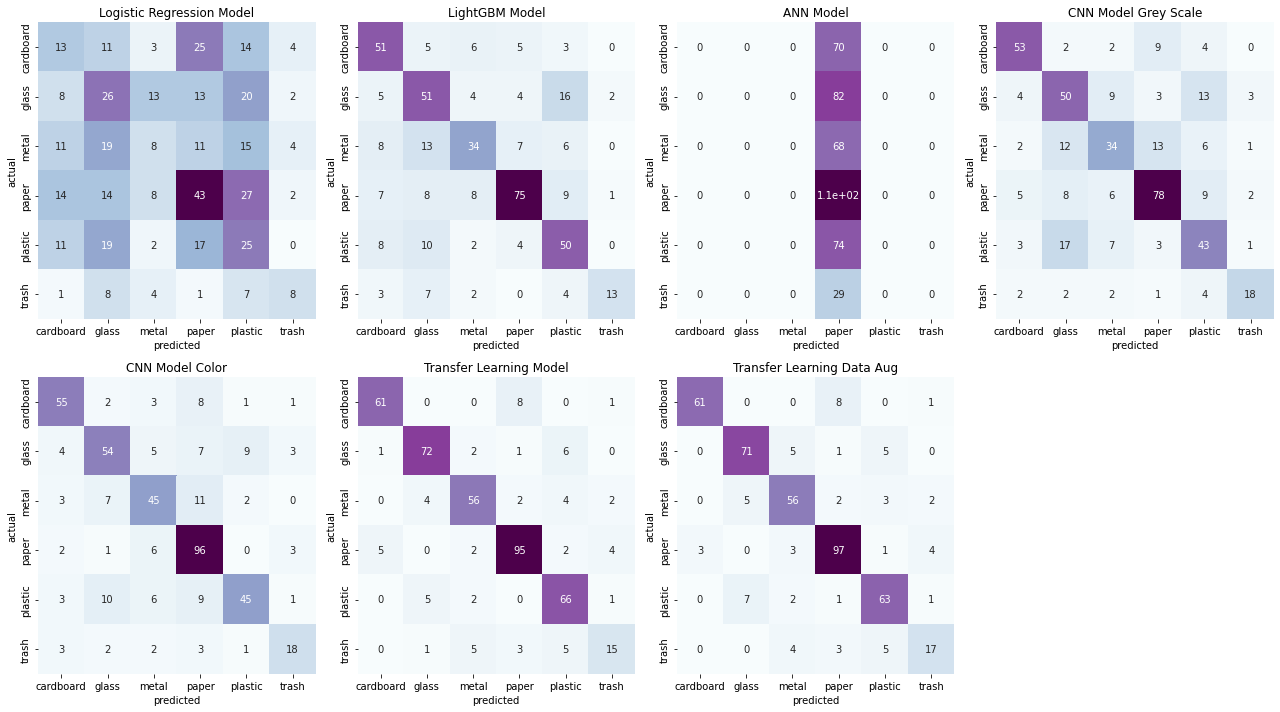

In [ ]:
# Positions in the grid:
idxs = []
for i in range(2):
    for j in range(4):
        if i+j!=4:
            idxs.append((i,j))
idxs = dict(zip(list(predictions.keys()), idxs))

fig, axes = plt.subplots(2, 4, figsize=(18, 10))

# Loop over selected models:
for f in predictions:
    sns.heatmap(conf_matrix[f], annot=True, cmap='BuPu', cbar=False, ax=axes[idxs[f]])
    axes[idxs[f]].set_xticklabels(labels=conf_matrix[f].columns, rotation=0)
    axes[idxs[f]].set_title(f'{model_assess[f]["data_modeling"]["label"]}')
    plt.tight_layout()

fig.delaxes(axes[1,3])

<a id='learning'></a>

### Learning process

In [ ]:
# Positions in the grid:
idxs = []
for i in range(2):
    for j in range(3):
        if i+j!=5:
            idxs.append((i+1,j+1))
idxs = dict(zip(nn_models, idxs))

# Declaring the grid of plots:
lineplot = LinePlot(
    grid=(2,3), width=1200, height=650,
    titles=nn_labels,
    legend=True
)

for f in nn_models:
    # Creating the plots:
    lineplot.add_plot(
        data=metrics_epoch[f], x='epoch', y=['loss', 'val_loss', 'val_accuracy'], position=idxs[f],
        colors=['blue', 'orange', 'green'],
        x_axis_name='epoch', y_axis_name='Cost',
        secondary_axis=[False, False, True]
    )

# Plotting the grid:
lineplot.render()

<a id='model_complex'></a>

### Model complexity

In [ ]:
model_complex = pd.DataFrame(data={
    'estimation_id': [m for m in selected_models],
    'model': [model_assess[m]['data_modeling']['label'] for m in selected_models],
    'accuracy': [model_assess[m]['model_eval']['test_accuracy'] for m in selected_models],
    'running_time': [model_assess[m]['model_eval']['running_time'] for m in selected_models],
    'params': [num_params(estimation_id=m, models=models, model_assess=model_assess)[0] for m in selected_models],
    'train_params': [num_params(estimation_id=m, models=models, model_assess=model_assess)[1] for m in selected_models],
    'hyper_params': [len(list(nested_dict_values(model_assess[m]['data_modeling']['model_params']))) for m in selected_models]
})

# Running time per accuracy percentage point:
model_complex['time_per_acc'] = model_complex['running_time']/model_complex['accuracy'].apply(lambda x: x*100)

# Number of parameters per accuracy percentage point:
model_complex['params_per_acc'] = model_complex['params']/model_complex['accuracy'].apply(lambda x: x*100)

# Number of trainable parameters per accuracy percentage point:
model_complex['train_per_acc'] = [
    p/(a*100) if pd.isna(t) else t/(a*100) for p, t, a in
    zip(model_complex['params'], model_complex['train_params'], model_complex['accuracy'])
]

print(f'Shape of model_complex: {model_complex.shape}.')
model_complex

Shape of model_complex: (7, 10).


estimation_id                       model  accuracy  running_time  \
0    1671558658   Logistic Regression Model  0.285383    578.173595   
1    1671631522              LightGBM Model  0.635731   2415.283374   
2    1671641950                   ANN Model  0.250580   1882.651781   
3    1671647818        CNN Model Grey Scale  0.640371     74.317148   
4    1671648238             CNN Model Color  0.726218    102.753999   
5    1672278906     Transfer Learning Model  0.846868    288.173277   
6    1672279582  Transfer Learning Data Aug  0.846868    366.548536   

      params  train_params  hyper_params  time_per_acc  params_per_acc  \
0     301062           NaN             4     20.259579    1.054941e+04   
1      18600           NaN             6     37.992231    2.925766e+02   
2  156162756   156162756.0            16     75.131752    6.232051e+06   
3    4337318     4337318.0            30      1.160532    6.773131e+04   
4    4337606     4337606.0            30      1.414919    5.972870e+04   
5   23487534     2626054.0            22      3.402813    2.773459e+05   
6   23487534     2626054.0            22      4.328285    2.773459e+05   

   train_per_acc  
0   1.054941e+04  
1   2.925766e+02  
2   6.232051e+06  
3   6.773131e+04  
4   5.972870e+04  
5   3.100902e+04  
6   3.100902e+04

#### Running time

In [ ]:
# Creating the grid:
plot = Plot(
    grid=(1,3), width=1200, height=550,
    titles=['Accuracy vs. running time', 'Running time per accuracy point', 'Running time per accuracy point'],
    template='plotly_dark',
    main_title='Model complexity: computing time'
)

# Declaring a plot:
plot.add_plot(
    data=model_complex, plot_type='scatter',
    x='running_time', y='accuracy', position=(1,1),
    colors=['orange'],
    x_axis_name='Running time', y_axis_name='Accuracy',
    text_vars=['model']
)
plot.add_plot(
    data=model_complex, plot_type='bar',
    x='model', y='time_per_acc', position=(1,2),
    colors=['orange'],
    x_axis_name='', y_axis_name='Time/Accuracy'
)
plot.add_plot(
    data=model_complex[model_complex.model!='ANN Model'], plot_type='bar',
    x='model', y='time_per_acc', position=(1,3),
    colors=['orange'],
    x_axis_name='', y_axis_name='Time/Accuracy'
)

# Plotting the grid:
plot.render()

#### Model parameters

In [ ]:
# Creating the grid:
plot = Plot(
    grid=(2,2), width=1200, height=650,
    titles=['Parameters per accuracy point', 'Trainable params per accuracy point',
            '', ''],
    template='plotly_dark',
    main_title='Model complexity: model parameters'
)

# Declaring a plot:
plot.add_plot(
    data=model_complex, plot_type='bar',
    x='model', y='params_per_acc', position=(1,1),
    colors=['orange'],
    x_axis_name='', y_axis_name='Parameters/Accuracy'
)
plot.add_plot(
    data=model_complex, plot_type='bar',
    x='model', y='train_per_acc', position=(1,2),
    colors=['orange'],
    x_axis_name='', y_axis_name='Trainable parameters/Accuracy'
)
plot.add_plot(
    data=model_complex[model_complex.model!='ANN Model'], plot_type='bar',
    x='model', y='params_per_acc', position=(2,1),
    colors=['orange'],
    x_axis_name='', y_axis_name='Parameters/Accuracy'
)
plot.add_plot(
    data=model_complex[model_complex.model!='ANN Model'], plot_type='bar',
    x='model', y='train_per_acc', position=(2,2),
    colors=['orange'],
    x_axis_name='', y_axis_name='Trainable parameters/Accuracy'
)

# Plotting the grid:
plot.render()

#### Experimentation

In [ ]:
# Count of experiments by method:
method_exper = {
    'LR': sum([model_assess[f]['data_modeling']['which_model']=='lr' for f in model_assess]),
    'LightGBM': sum([model_assess[f]['data_modeling']['which_model']=='lgb' for f in model_assess]),
    'ANN': sum([model_assess[f]['data_modeling']['which_model']=='ann' for f in model_assess]),
    'CNN': sum([model_assess[f]['data_modeling']['which_model']=='cnn' for f in model_assess]),
    'Transfer': sum([model_assess[f]['data_modeling']['which_model']=='transfer' for f in model_assess])
}

# Median of accurcy by method:
acc_method = {
    'LR': np.nanmedian([
        model_assess[f]['model_eval']['test_accuracy'] for f in
        [f for f in model_assess if model_assess[f]['data_modeling']['which_model']=='lr']
    ]),
    'LightGBM': np.nanmedian([
        model_assess[f]['model_eval']['test_accuracy'] for f in
        [f for f in model_assess if model_assess[f]['data_modeling']['which_model']=='lgb']
    ]),
    'ANN': np.nanmedian([
        model_assess[f]['model_eval']['test_accuracy'] for f in
        [f for f in model_assess if model_assess[f]['data_modeling']['which_model']=='ann']
    ]),
    'CNN': np.nanmedian([
        model_assess[f]['model_eval']['test_accuracy'] for f in
        [f for f in model_assess if model_assess[f]['data_modeling']['which_model']=='cnn']
    ]),
    'Transfer': np.nanmedian([
        model_assess[f]['model_eval']['test_accuracy'] for f in
        [f for f in model_assess if model_assess[f]['data_modeling']['which_model']=='transfer']
    ])
}

method_exper = pd.DataFrame(
    data={'method': method_exper.keys(), 'num_exper': method_exper.values(), 'acc_med': acc_method.values()}
)
method_exper

method  num_exper   acc_med
0        LR          2  0.285383
1  LightGBM          2  0.635731
2       ANN          5  0.250580
3       CNN         92  0.641531
4  Transfer         27  0.837587

In [ ]:
# Creating the grid:
plot = Plot(
    grid=(1,2), width=950, height=450,
    titles=['Accuracy vs. number of hyper-params', 'Number of experiments per method'],
    template='plotly_dark',
    main_title='Model complexity: experimentation'
)

# Declaring a plot:
plot.add_plot(
    data=model_complex, plot_type='scatter',
    x='hyper_params', y='accuracy', position=(1,1),
    colors=['orange'],
    x_axis_name='Num hyper-params', y_axis_name='Accuracy',
    text_vars=['model']
)
plot.add_plot(
    data=method_exper, plot_type='bar',
    x='method', y='num_exper', position=(1,2),
    colors=['orange'],
    x_axis_name='', y_axis_name='Number of experiments'
)

# Plotting the grid:
plot.render()

<a id='by_class'></a>

## Performance by class

<a id='pred_proba'><a/>

### Predicted probabilities

In [ ]:
# Predicted probability for each class:
predictions_prob = [
    p for p in models[best_model].model.predict(images_test_scaled)
]

In [ ]:
# Predicted probability for each class:
predictions_prob = pd.DataFrame(predictions_prob, columns=list(label_dict.keys()))

# Predicted class:
predictions_prob['pred_class'] = [
    list(label_dict.keys())[predictions_prob.iloc[i].argmax()] for
    i in range(len(predictions_prob))
]

# True class:
predictions_prob['true_class'] = [label_to_class[l] for l in labels_test]

# Images ID:
predictions_prob['id'] = [i for i in ids_test]

print(f'Shape of predictions_prob: {predictions_prob.shape}.')
predictions_prob.head(10)

Shape of predictions_prob: (431, 9).


cardboard         glass         metal         paper       plastic  \
0  1.356071e-09  1.232532e-11  1.826399e-12  9.999967e-01  3.300985e-06   
1  2.194864e-06  1.029200e-04  1.379585e-04  2.123059e-03  9.976158e-01   
2  4.185940e-13  4.481356e-11  9.560961e-12  6.296023e-11  1.000000e+00   
3  3.561524e-07  8.128615e-04  2.979594e-02  6.170151e-07  9.693857e-01   
4  6.162302e-07  1.089761e-10  3.053589e-10  9.999993e-01  9.877932e-08   
5  9.044782e-12  1.000000e+00  2.671203e-11  5.863980e-09  8.500253e-09   
6  9.999797e-01  2.082555e-15  1.155193e-13  2.030652e-05  2.015215e-12   
7  2.578346e-10  8.370803e-08  2.459971e-09  3.431007e-09  9.999999e-01   
8  4.936326e-09  9.993456e-01  3.723571e-08  3.826479e-08  6.543492e-04   
9  1.757960e-03  5.945801e-09  4.136655e-11  9.981494e-01  2.098665e-05   

          trash pred_class true_class            id  
0  1.202210e-10      paper      paper      paper495  
1  1.804676e-05    plastic    plastic    plastic317  
2  3.900239e-12    plastic    plastic    plastic312  
3  4.451818e-06    plastic      glass      glass385  
4  8.631192e-09      paper      paper      paper186  
5  8.970157e-11      glass      glass      glass373  
6  3.404938e-10  cardboard  cardboard  cardboard125  
7  2.229745e-08    plastic    plastic    plastic265  
8  1.186345e-08      glass      glass      glass310  
9  7.169804e-05      paper      paper      paper368

<a id='perf_metrics'></a>

### Performance metrics

              precision    recall  f1-score   support

   cardboard       0.91      0.87      0.89        70
       glass       0.88      0.88      0.88        82
       metal       0.84      0.82      0.83        68
       paper       0.87      0.88      0.88       108
     plastic       0.80      0.89      0.84        74
       trash       0.65      0.52      0.58        29

    accuracy                           0.85       431
   macro avg       0.82      0.81      0.82       431
weighted avg       0.85      0.85      0.85       431



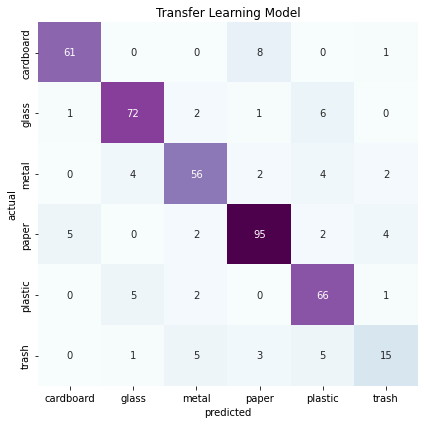

In [ ]:
print(
    classification_report(
        y_true=[l for l in labels_test], y_pred=predictions[best_model],
        labels=list(label_dict.values()),
        target_names=list(label_dict.keys())
    )
)

plt.figure(figsize=(6,6))

sns.heatmap(conf_matrix[best_model], annot=True, cmap='BuPu', cbar=False)

plt.xticks(rotation=0)
plt.title(f'{model_assess[best_model]["data_modeling"]["label"]}')
plt.tight_layout()

#### Wrongly predicted as trash

In [ ]:
predictions_prob['pred_trash'] = predictions_prob['pred_class'].apply(lambda x: x=='trash')

print(f'Shape of predictions_prob: {predictions_prob.shape}.')
predictions_prob.head(3)

Shape of predictions_prob: (431, 10).


cardboard         glass         metal         paper   plastic  \
0  1.356071e-09  1.232532e-11  1.826399e-12  9.999967e-01  0.000003   
1  2.194864e-06  1.029200e-04  1.379585e-04  2.123059e-03  0.997616   
2  4.185940e-13  4.481356e-11  9.560961e-12  6.296023e-11  1.000000   

          trash pred_class true_class          id  pred_trash  
0  1.202210e-10      paper      paper    paper495       False  
1  1.804676e-05    plastic    plastic  plastic317       False  
2  3.900239e-12    plastic    plastic  plastic312       False

In [ ]:
predictions_prob[predictions_prob.true_class!='trash'].groupby('true_class').mean()[['pred_trash']]

pred_trash
true_class            
cardboard     0.014286
glass         0.000000
metal         0.029412
paper         0.037037
plastic       0.013514

In [ ]:
predictions_prob[
    (predictions_prob.true_class!='trash') &
    (predictions_prob.true_class!=predictions_prob.pred_class)
].groupby('true_class').mean()[['pred_trash']]

pred_trash
true_class            
cardboard     0.111111
glass         0.000000
metal         0.166667
paper         0.307692
plastic       0.125000

<a id='errors'></a>

### Errors

In [ ]:
pd.options.display.float_format = '{:,.4f}'.format

In [ ]:
# Maximum predicted probability of other classes than the correct one:
predictions_prob['miss_prob'] = predictions_prob.apply(
    lambda x:
    max(x[[c for c in list(label_dict.keys()) if c!=x['true_class']]]),
    axis=1
)

# Maximum predicted probability of the correct class:
predictions_prob['true_prob'] = predictions_prob.apply(
    lambda x:
    x[x['true_class']],
    axis=1
)

print(f'Shape of predictions_prob: {predictions_prob.shape}.')
predictions_prob.head(10)

Shape of predictions_prob: (431, 12).


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
0     0.0000 0.0000 0.0000 1.0000   0.0000 0.0000      paper      paper   
1     0.0000 0.0001 0.0001 0.0021   0.9976 0.0000    plastic    plastic   
2     0.0000 0.0000 0.0000 0.0000   1.0000 0.0000    plastic    plastic   
3     0.0000 0.0008 0.0298 0.0000   0.9694 0.0000    plastic      glass   
4     0.0000 0.0000 0.0000 1.0000   0.0000 0.0000      paper      paper   
5     0.0000 1.0000 0.0000 0.0000   0.0000 0.0000      glass      glass   
6     1.0000 0.0000 0.0000 0.0000   0.0000 0.0000  cardboard  cardboard   
7     0.0000 0.0000 0.0000 0.0000   1.0000 0.0000    plastic    plastic   
8     0.0000 0.9993 0.0000 0.0000   0.0007 0.0000      glass      glass   
9     0.0018 0.0000 0.0000 0.9981   0.0000 0.0001      paper      paper   

             id  pred_trash  miss_prob  true_prob  
0      paper495       False     0.0000     1.0000  
1    plastic317       False     0.0021     0.9976  
2    plastic312       False     0.0000     1.0000  
3      glass385       False     0.9694     0.0008  
4      paper186       False     0.0000     1.0000  
5      glass373       False     0.0000     1.0000  
6  cardboard125       False     0.0000     1.0000  
7    plastic265       False     0.0000     1.0000  
8      glass310       False     0.0007     0.9993  
9      paper368       False     0.0018     0.9981

In [ ]:
predictions_prob[
    predictions_prob.true_class!=predictions_prob.pred_class
].groupby('true_class').mean()[['miss_prob']].sort_values('miss_prob', ascending=False)

miss_prob
true_class           
plastic        0.9423
trash          0.9118
paper          0.8866
cardboard      0.8796
glass          0.8313
metal          0.8199

In [ ]:
predictions_prob[
    predictions_prob.true_class!=predictions_prob.pred_class
].groupby('true_class').mean()[['true_prob']].sort_values('true_prob', ascending=False)

true_prob
true_class           
glass          0.1186
metal          0.0997
trash          0.0802
cardboard      0.0740
paper          0.0736
plastic        0.0451

#### Cardboard

Major errors

In [ ]:
major_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='cardboard')
].sort_values('miss_prob', ascending=False).head(10)

print(major_errors['pred_class'].value_counts(normalize=True))
major_errors

paper   0.8889
trash   0.1111
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
100     0.0000 0.0000 0.0000 1.0000   0.0000 0.0000      paper  cardboard   
384     0.0001 0.0000 0.0000 0.9999   0.0000 0.0000      paper  cardboard   
138     0.0037 0.0000 0.0000 0.9963   0.0000 0.0000      paper  cardboard   
142     0.0031 0.0017 0.0000 0.9952   0.0000 0.0000      paper  cardboard   
20      0.0000 0.0004 0.0052 0.9944   0.0000 0.0000      paper  cardboard   
380     0.0001 0.0000 0.0093 0.9906   0.0000 0.0000      paper  cardboard   
267     0.2648 0.0000 0.0000 0.7352   0.0000 0.0001      paper  cardboard   
246     0.3687 0.0000 0.0000 0.6313   0.0000 0.0000      paper  cardboard   
247     0.0258 0.0125 0.0000 0.0006   0.3871 0.5740      trash  cardboard   

               id  pred_trash  miss_prob  true_prob  
100  cardboard190       False     1.0000     0.0000  
384  cardboard286       False     0.9999     0.0001  
138  cardboard266       False     0.9963     0.0037  
142   cardboard98       False     0.9952     0.0031  
20   cardboard162       False     0.9944     0.0000  
380  cardboard128       False     0.9906     0.0001  
267  cardboard239       False     0.7352     0.2648  
246  cardboard274       False     0.6313     0.3687  
247  cardboard290        True     0.5740     0.0258

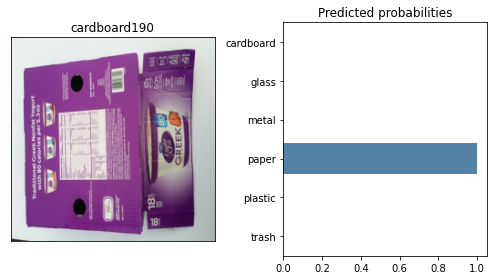

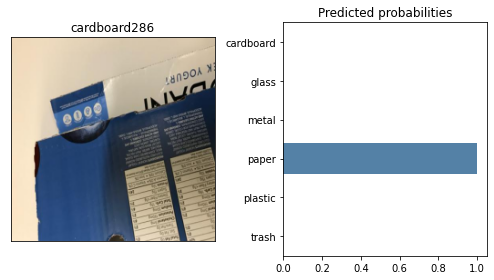

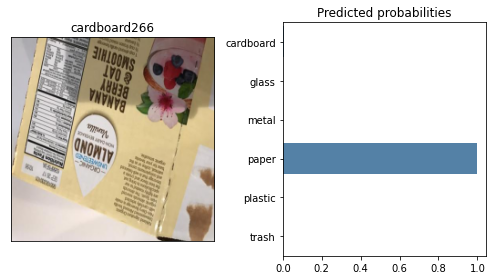

In [ ]:
# Loop over major errors:
for i in range(min([len(major_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[major_errors.index[i], :, :, :])
    axs[0].set_title(major_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].values,
        y=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Minor errors

In [ ]:
minor_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='cardboard')
].sort_values('true_prob', ascending=False).head(10)

print(minor_errors['pred_class'].value_counts(normalize=True))
minor_errors

paper   0.8889
trash   0.1111
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
246     0.3687 0.0000 0.0000 0.6313   0.0000 0.0000      paper  cardboard   
267     0.2648 0.0000 0.0000 0.7352   0.0000 0.0001      paper  cardboard   
247     0.0258 0.0125 0.0000 0.0006   0.3871 0.5740      trash  cardboard   
138     0.0037 0.0000 0.0000 0.9963   0.0000 0.0000      paper  cardboard   
142     0.0031 0.0017 0.0000 0.9952   0.0000 0.0000      paper  cardboard   
384     0.0001 0.0000 0.0000 0.9999   0.0000 0.0000      paper  cardboard   
380     0.0001 0.0000 0.0093 0.9906   0.0000 0.0000      paper  cardboard   
20      0.0000 0.0004 0.0052 0.9944   0.0000 0.0000      paper  cardboard   
100     0.0000 0.0000 0.0000 1.0000   0.0000 0.0000      paper  cardboard   

               id  pred_trash  miss_prob  true_prob  
246  cardboard274       False     0.6313     0.3687  
267  cardboard239       False     0.7352     0.2648  
247  cardboard290        True     0.5740     0.0258  
138  cardboard266       False     0.9963     0.0037  
142   cardboard98       False     0.9952     0.0031  
384  cardboard286       False     0.9999     0.0001  
380  cardboard128       False     0.9906     0.0001  
20   cardboard162       False     0.9944     0.0000  
100  cardboard190       False     1.0000     0.0000

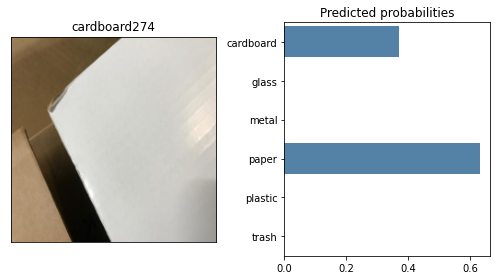

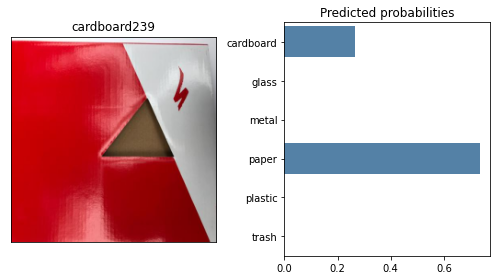

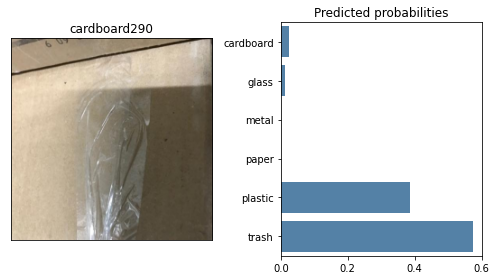

In [ ]:
# Loop over major errors:
for i in range(min([len(minor_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[minor_errors.index[i], :, :, :])
    axs[0].set_title(minor_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].values,
        y=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Confused predictions

In [ ]:
conf_preds = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='cardboard')
].sort_values('miss_prob', ascending=True).head(10)

print(conf_preds['pred_class'].value_counts(normalize=True))
conf_preds

paper   0.8889
trash   0.1111
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
247     0.0258 0.0125 0.0000 0.0006   0.3871 0.5740      trash  cardboard   
246     0.3687 0.0000 0.0000 0.6313   0.0000 0.0000      paper  cardboard   
267     0.2648 0.0000 0.0000 0.7352   0.0000 0.0001      paper  cardboard   
380     0.0001 0.0000 0.0093 0.9906   0.0000 0.0000      paper  cardboard   
20      0.0000 0.0004 0.0052 0.9944   0.0000 0.0000      paper  cardboard   
142     0.0031 0.0017 0.0000 0.9952   0.0000 0.0000      paper  cardboard   
138     0.0037 0.0000 0.0000 0.9963   0.0000 0.0000      paper  cardboard   
384     0.0001 0.0000 0.0000 0.9999   0.0000 0.0000      paper  cardboard   
100     0.0000 0.0000 0.0000 1.0000   0.0000 0.0000      paper  cardboard   

               id  pred_trash  miss_prob  true_prob  
247  cardboard290        True     0.5740     0.0258  
246  cardboard274       False     0.6313     0.3687  
267  cardboard239       False     0.7352     0.2648  
380  cardboard128       False     0.9906     0.0001  
20   cardboard162       False     0.9944     0.0000  
142   cardboard98       False     0.9952     0.0031  
138  cardboard266       False     0.9963     0.0037  
384  cardboard286       False     0.9999     0.0001  
100  cardboard190       False     1.0000     0.0000

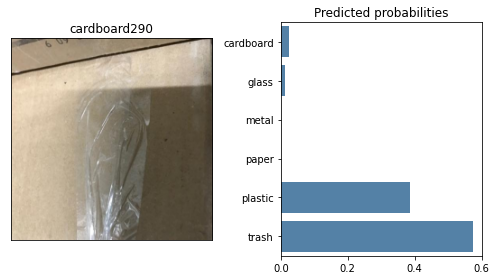

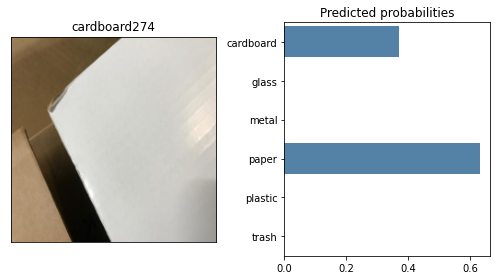

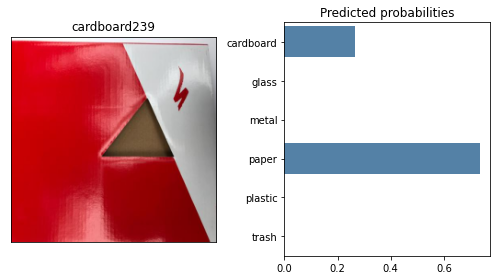

In [ ]:
# Loop over major errors:
for i in range(min([len(conf_preds), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[conf_preds.index[i], :, :, :])
    axs[0].set_title(conf_preds['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].values,
        y=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

#### Glass

Major errors

In [ ]:
major_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='glass')
].sort_values('miss_prob', ascending=False).head(10)

print(major_errors['pred_class'].value_counts(normalize=True))
major_errors

plastic     0.6000
metal       0.2000
cardboard   0.1000
paper       0.1000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
172     0.0000 0.0000 0.0000 0.0000   1.0000 0.0000    plastic      glass   
109     0.0000 0.0001 0.0000 0.0000   0.9999 0.0000    plastic      glass   
3       0.0000 0.0008 0.0298 0.0000   0.9694 0.0000    plastic      glass   
343     0.9387 0.0607 0.0002 0.0000   0.0001 0.0004  cardboard      glass   
185     0.0006 0.0889 0.0187 0.0010   0.8898 0.0010    plastic      glass   
139     0.0000 0.1263 0.8737 0.0000   0.0000 0.0000      metal      glass   
196     0.0000 0.1862 0.8061 0.0013   0.0060 0.0003      metal      glass   
135     0.0000 0.2402 0.0321 0.7143   0.0131 0.0003      paper      glass   
223     0.0000 0.0381 0.2892 0.0988   0.5735 0.0003    plastic      glass   
22      0.0000 0.4449 0.0075 0.0000   0.5476 0.0000    plastic      glass   

           id  pred_trash  miss_prob  true_prob  
172  glass350       False     1.0000     0.0000  
109  glass267       False     0.9999     0.0001  
3    glass385       False     0.9694     0.0008  
343   glass12       False     0.9387     0.0607  
185   glass10       False     0.8898     0.0889  
139  glass192       False     0.8737     0.1263  
196   glass61       False     0.8061     0.1862  
135  glass148       False     0.7143     0.2402  
223   glass57       False     0.5735     0.0381  
22   glass323       False     0.5476     0.4449

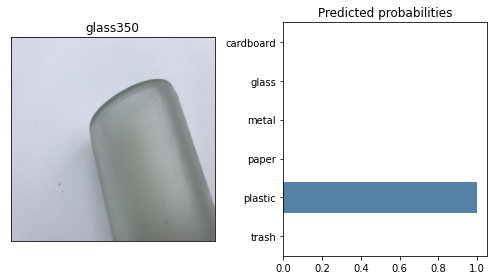

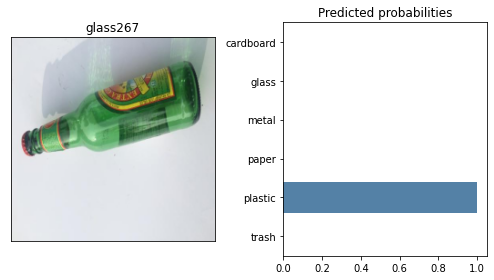

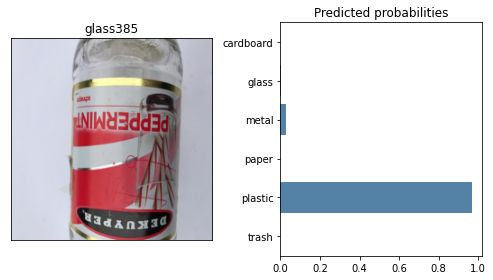

In [ ]:
# Loop over major errors:
for i in range(min([len(major_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[major_errors.index[i], :, :, :])
    axs[0].set_title(major_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].values,
        y=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Minor errors

In [ ]:
minor_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='glass')
].sort_values('true_prob', ascending=False).head(10)

print(minor_errors['pred_class'].value_counts(normalize=True))
minor_errors

plastic     0.6000
metal       0.2000
paper       0.1000
cardboard   0.1000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
22      0.0000 0.4449 0.0075 0.0000   0.5476 0.0000    plastic      glass   
135     0.0000 0.2402 0.0321 0.7143   0.0131 0.0003      paper      glass   
196     0.0000 0.1862 0.8061 0.0013   0.0060 0.0003      metal      glass   
139     0.0000 0.1263 0.8737 0.0000   0.0000 0.0000      metal      glass   
185     0.0006 0.0889 0.0187 0.0010   0.8898 0.0010    plastic      glass   
343     0.9387 0.0607 0.0002 0.0000   0.0001 0.0004  cardboard      glass   
223     0.0000 0.0381 0.2892 0.0988   0.5735 0.0003    plastic      glass   
3       0.0000 0.0008 0.0298 0.0000   0.9694 0.0000    plastic      glass   
109     0.0000 0.0001 0.0000 0.0000   0.9999 0.0000    plastic      glass   
172     0.0000 0.0000 0.0000 0.0000   1.0000 0.0000    plastic      glass   

           id  pred_trash  miss_prob  true_prob  
22   glass323       False     0.5476     0.4449  
135  glass148       False     0.7143     0.2402  
196   glass61       False     0.8061     0.1862  
139  glass192       False     0.8737     0.1263  
185   glass10       False     0.8898     0.0889  
343   glass12       False     0.9387     0.0607  
223   glass57       False     0.5735     0.0381  
3    glass385       False     0.9694     0.0008  
109  glass267       False     0.9999     0.0001  
172  glass350       False     1.0000     0.0000

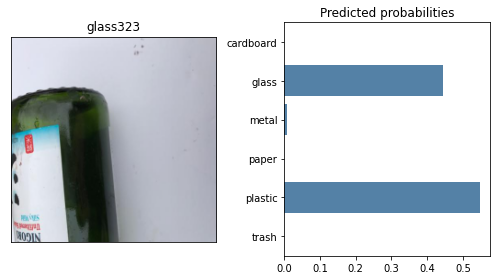

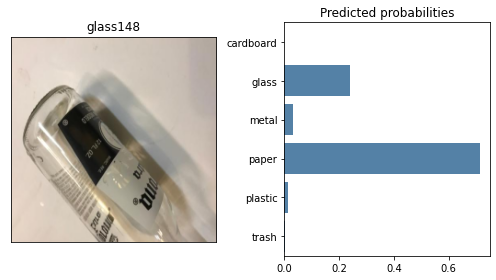

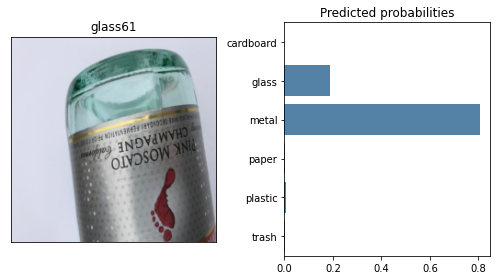

In [ ]:
# Loop over major errors:
for i in range(min([len(minor_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[minor_errors.index[i], :, :, :])
    axs[0].set_title(minor_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].values,
        y=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Confused predictions

In [ ]:
conf_preds = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='glass')
].sort_values('miss_prob', ascending=True).head(10)

print(conf_preds['pred_class'].value_counts(normalize=True))
conf_preds

plastic     0.6000
metal       0.2000
paper       0.1000
cardboard   0.1000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
22      0.0000 0.4449 0.0075 0.0000   0.5476 0.0000    plastic      glass   
223     0.0000 0.0381 0.2892 0.0988   0.5735 0.0003    plastic      glass   
135     0.0000 0.2402 0.0321 0.7143   0.0131 0.0003      paper      glass   
196     0.0000 0.1862 0.8061 0.0013   0.0060 0.0003      metal      glass   
139     0.0000 0.1263 0.8737 0.0000   0.0000 0.0000      metal      glass   
185     0.0006 0.0889 0.0187 0.0010   0.8898 0.0010    plastic      glass   
343     0.9387 0.0607 0.0002 0.0000   0.0001 0.0004  cardboard      glass   
3       0.0000 0.0008 0.0298 0.0000   0.9694 0.0000    plastic      glass   
109     0.0000 0.0001 0.0000 0.0000   0.9999 0.0000    plastic      glass   
172     0.0000 0.0000 0.0000 0.0000   1.0000 0.0000    plastic      glass   

           id  pred_trash  miss_prob  true_prob  
22   glass323       False     0.5476     0.4449  
223   glass57       False     0.5735     0.0381  
135  glass148       False     0.7143     0.2402  
196   glass61       False     0.8061     0.1862  
139  glass192       False     0.8737     0.1263  
185   glass10       False     0.8898     0.0889  
343   glass12       False     0.9387     0.0607  
3    glass385       False     0.9694     0.0008  
109  glass267       False     0.9999     0.0001  
172  glass350       False     1.0000     0.0000

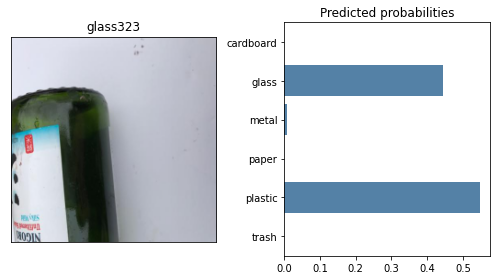

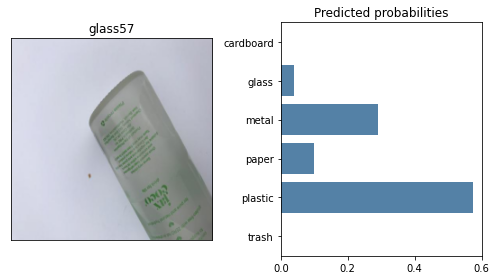

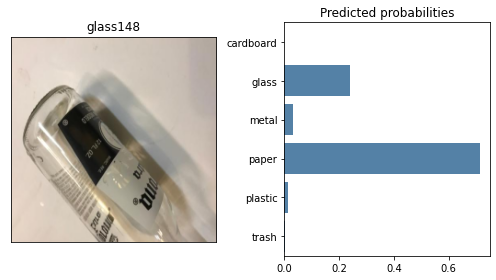

In [ ]:
# Loop over major errors:
for i in range(min([len(conf_preds), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[conf_preds.index[i], :, :, :])
    axs[0].set_title(conf_preds['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].values,
        y=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

#### Metal

Major errors

In [ ]:
major_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='metal')
].sort_values('miss_prob', ascending=False).head(10)

print(major_errors['pred_class'].value_counts(normalize=True))
major_errors

glass     0.4000
plastic   0.4000
trash     0.2000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
45      0.0000 1.0000 0.0000 0.0000   0.0000 0.0000      glass      metal   
338     0.0000 0.9996 0.0004 0.0000   0.0000 0.0000      glass      metal   
191     0.0000 0.0000 0.0014 0.0000   0.9985 0.0001    plastic      metal   
273     0.0000 0.0000 0.0026 0.0047   0.9927 0.0000    plastic      metal   
325     0.0000 0.9926 0.0059 0.0000   0.0015 0.0000      glass      metal   
234     0.0000 0.0160 0.1190 0.0051   0.8599 0.0000    plastic      metal   
295     0.0000 0.0000 0.1927 0.0002   0.0003 0.8068      trash      metal   
60      0.0000 0.0128 0.2211 0.0003   0.7657 0.0001    plastic      metal   
217     0.0000 0.0000 0.3038 0.0238   0.0000 0.6724      trash      metal   
390     0.0018 0.6470 0.0280 0.0006   0.1307 0.1919      glass      metal   

           id  pred_trash  miss_prob  true_prob  
45   metal157       False     1.0000     0.0000  
338  metal248       False     0.9996     0.0004  
191  metal175       False     0.9985     0.0014  
273  metal393       False     0.9927     0.0026  
325  metal355       False     0.9926     0.0059  
234  metal186       False     0.8599     0.1190  
295  metal209        True     0.8068     0.1927  
60   metal364       False     0.7657     0.2211  
217  metal201        True     0.6724     0.3038  
390   metal48       False     0.6470     0.0280

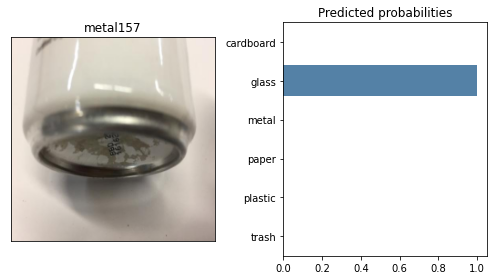

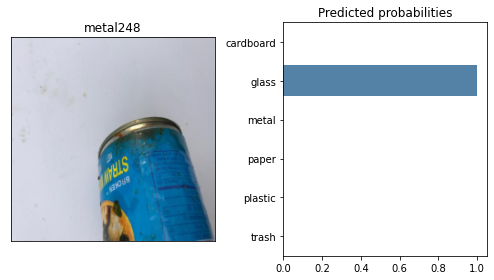

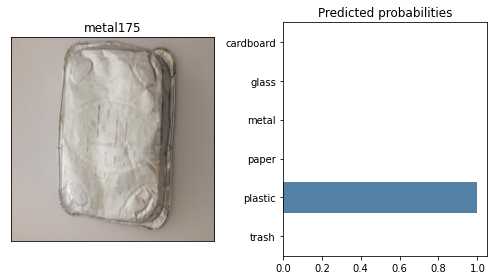

In [ ]:
# Loop over major errors:
for i in range(min([len(major_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[major_errors.index[i], :, :, :])
    axs[0].set_title(major_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].values,
        y=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Minor errors

In [ ]:
minor_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='metal')
].sort_values('true_prob', ascending=False).head(10)

print(minor_errors['pred_class'].value_counts(normalize=True))
minor_errors

plastic   0.4000
paper     0.2000
trash     0.2000
glass     0.2000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
225     0.0051 0.0000 0.3171 0.5617   0.0059 0.1102      paper      metal   
217     0.0000 0.0000 0.3038 0.0238   0.0000 0.6724      trash      metal   
60      0.0000 0.0128 0.2211 0.0003   0.7657 0.0001    plastic      metal   
295     0.0000 0.0000 0.1927 0.0002   0.0003 0.8068      trash      metal   
234     0.0000 0.0160 0.1190 0.0051   0.8599 0.0000    plastic      metal   
390     0.0018 0.6470 0.0280 0.0006   0.1307 0.1919      glass      metal   
325     0.0000 0.9926 0.0059 0.0000   0.0015 0.0000      glass      metal   
133     0.0000 0.0091 0.0048 0.5422   0.4438 0.0001      paper      metal   
273     0.0000 0.0000 0.0026 0.0047   0.9927 0.0000    plastic      metal   
191     0.0000 0.0000 0.0014 0.0000   0.9985 0.0001    plastic      metal   

           id  pred_trash  miss_prob  true_prob  
225  metal134       False     0.5617     0.3171  
217  metal201        True     0.6724     0.3038  
60   metal364       False     0.7657     0.2211  
295  metal209        True     0.8068     0.1927  
234  metal186       False     0.8599     0.1190  
390   metal48       False     0.6470     0.0280  
325  metal355       False     0.9926     0.0059  
133  metal403       False     0.5422     0.0048  
273  metal393       False     0.9927     0.0026  
191  metal175       False     0.9985     0.0014

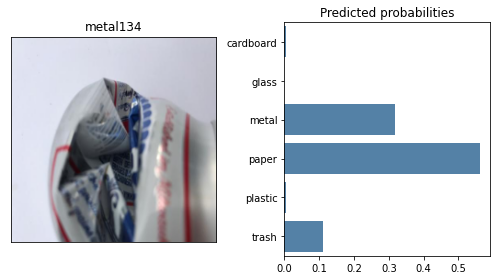

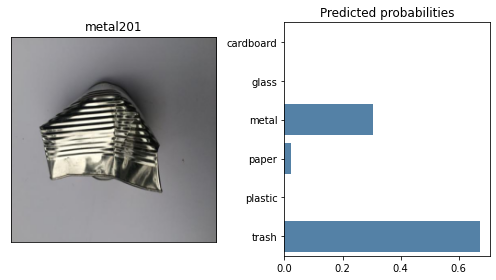

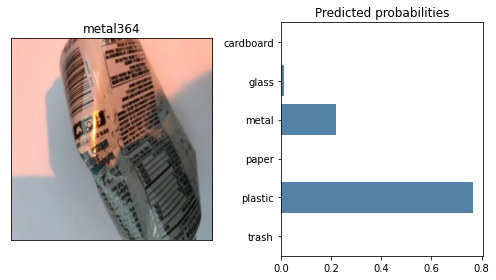

In [ ]:
# Loop over major errors:
for i in range(min([len(minor_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[minor_errors.index[i], :, :, :])
    axs[0].set_title(minor_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].values,
        y=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Confused predictions

In [ ]:
conf_preds = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='metal')
].sort_values('miss_prob', ascending=True).head(10)

print(conf_preds['pred_class'].value_counts(normalize=True))
conf_preds

plastic   0.4000
paper     0.2000
glass     0.2000
trash     0.2000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
133     0.0000 0.0091 0.0048 0.5422   0.4438 0.0001      paper      metal   
225     0.0051 0.0000 0.3171 0.5617   0.0059 0.1102      paper      metal   
390     0.0018 0.6470 0.0280 0.0006   0.1307 0.1919      glass      metal   
217     0.0000 0.0000 0.3038 0.0238   0.0000 0.6724      trash      metal   
60      0.0000 0.0128 0.2211 0.0003   0.7657 0.0001    plastic      metal   
295     0.0000 0.0000 0.1927 0.0002   0.0003 0.8068      trash      metal   
234     0.0000 0.0160 0.1190 0.0051   0.8599 0.0000    plastic      metal   
325     0.0000 0.9926 0.0059 0.0000   0.0015 0.0000      glass      metal   
273     0.0000 0.0000 0.0026 0.0047   0.9927 0.0000    plastic      metal   
191     0.0000 0.0000 0.0014 0.0000   0.9985 0.0001    plastic      metal   

           id  pred_trash  miss_prob  true_prob  
133  metal403       False     0.5422     0.0048  
225  metal134       False     0.5617     0.3171  
390   metal48       False     0.6470     0.0280  
217  metal201        True     0.6724     0.3038  
60   metal364       False     0.7657     0.2211  
295  metal209        True     0.8068     0.1927  
234  metal186       False     0.8599     0.1190  
325  metal355       False     0.9926     0.0059  
273  metal393       False     0.9927     0.0026  
191  metal175       False     0.9985     0.0014

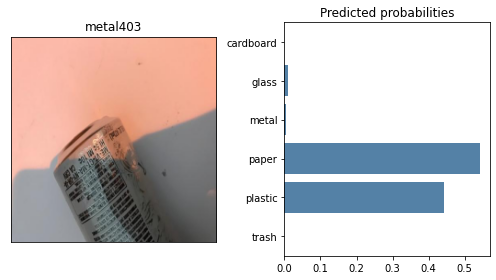

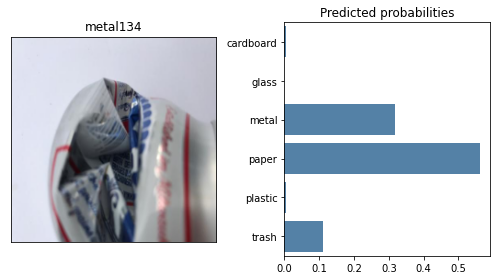

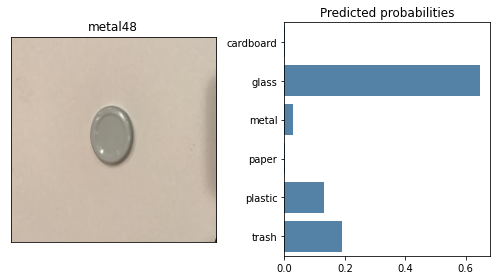

In [ ]:
# Loop over major errors:
for i in range(min([len(conf_preds), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[conf_preds.index[i], :, :, :])
    axs[0].set_title(conf_preds['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].values,
        y=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

#### Paper

Major errors

In [ ]:
major_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='paper')
].sort_values('miss_prob', ascending=False).head(10)

print(major_errors['pred_class'].value_counts(normalize=True))
major_errors

trash       0.4000
cardboard   0.3000
metal       0.2000
plastic     0.1000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
132     0.0000 0.0000 1.0000 0.0000   0.0000 0.0000      metal      paper   
209     0.9998 0.0000 0.0000 0.0002   0.0000 0.0000  cardboard      paper   
397     0.9989 0.0000 0.0000 0.0011   0.0000 0.0000  cardboard      paper   
178     0.0000 0.0001 0.0000 0.0017   0.9974 0.0008    plastic      paper   
285     0.0000 0.0000 0.9914 0.0000   0.0079 0.0006      metal      paper   
19      0.9825 0.0000 0.0000 0.0175   0.0000 0.0000  cardboard      paper   
189     0.0000 0.0000 0.0000 0.0218   0.0000 0.9782      trash      paper   
366     0.0000 0.0000 0.0000 0.0237   0.0054 0.9709      trash      paper   
375     0.0000 0.0000 0.0000 0.0895   0.0032 0.9073      trash      paper   
365     0.0209 0.0000 0.0000 0.0674   0.0104 0.9014      trash      paper   

           id  pred_trash  miss_prob  true_prob  
132  paper209       False     1.0000     0.0000  
209  paper137       False     0.9998     0.0002  
397    paper6       False     0.9989     0.0011  
178  paper593       False     0.9974     0.0017  
285  paper563       False     0.9914     0.0000  
19   paper462       False     0.9825     0.0175  
189  paper276        True     0.9782     0.0218  
366  paper120        True     0.9709     0.0237  
375  paper548        True     0.9073     0.0895  
365  paper434        True     0.9014     0.0674

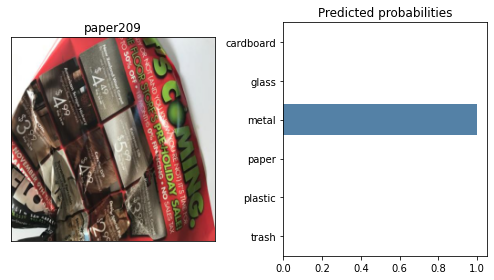

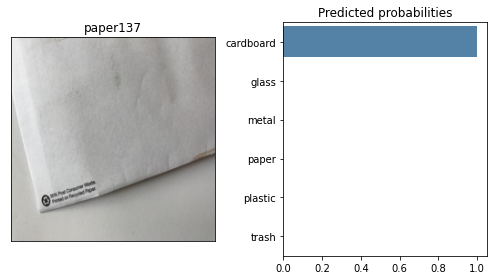

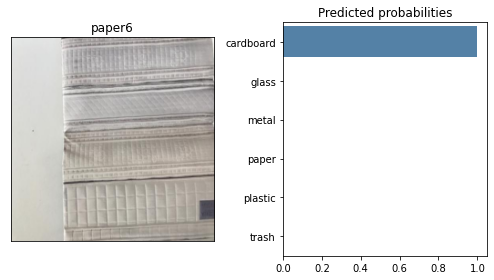

In [ ]:
# Loop over major errors:
for i in range(min([len(major_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[major_errors.index[i], :, :, :])
    axs[0].set_title(major_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].values,
        y=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Minor errors

In [ ]:
minor_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='paper')
].sort_values('true_prob', ascending=False).head(10)

print(minor_errors['pred_class'].value_counts(normalize=True))
minor_errors

cardboard   0.5000
trash       0.4000
plastic     0.1000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
291     0.5122 0.0000 0.0000 0.4878   0.0000 0.0000  cardboard      paper   
248     0.7544 0.0000 0.0000 0.2456   0.0000 0.0000  cardboard      paper   
375     0.0000 0.0000 0.0000 0.0895   0.0032 0.9073      trash      paper   
365     0.0209 0.0000 0.0000 0.0674   0.0104 0.9014      trash      paper   
366     0.0000 0.0000 0.0000 0.0237   0.0054 0.9709      trash      paper   
189     0.0000 0.0000 0.0000 0.0218   0.0000 0.9782      trash      paper   
19      0.9825 0.0000 0.0000 0.0175   0.0000 0.0000  cardboard      paper   
178     0.0000 0.0001 0.0000 0.0017   0.9974 0.0008    plastic      paper   
397     0.9989 0.0000 0.0000 0.0011   0.0000 0.0000  cardboard      paper   
209     0.9998 0.0000 0.0000 0.0002   0.0000 0.0000  cardboard      paper   

           id  pred_trash  miss_prob  true_prob  
291    paper7       False     0.5122     0.4878  
248  paper576       False     0.7544     0.2456  
375  paper548        True     0.9073     0.0895  
365  paper434        True     0.9014     0.0674  
366  paper120        True     0.9709     0.0237  
189  paper276        True     0.9782     0.0218  
19   paper462       False     0.9825     0.0175  
178  paper593       False     0.9974     0.0017  
397    paper6       False     0.9989     0.0011  
209  paper137       False     0.9998     0.0002

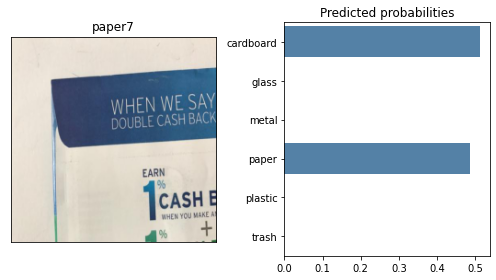

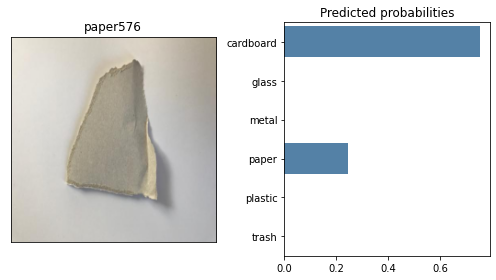

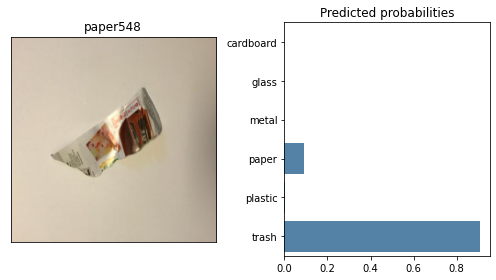

In [ ]:
# Loop over major errors:
for i in range(min([len(minor_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[minor_errors.index[i], :, :, :])
    axs[0].set_title(minor_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].values,
        y=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Confused predictions

In [ ]:
conf_preds = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='paper')
].sort_values('miss_prob', ascending=True).head(10)

print(conf_preds['pred_class'].value_counts(normalize=True))
conf_preds

trash       0.4000
cardboard   0.3000
plastic     0.2000
metal       0.1000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
291     0.5122 0.0000 0.0000 0.4878   0.0000 0.0000  cardboard      paper   
49      0.0000 0.0000 0.4690 0.0000   0.5310 0.0000    plastic      paper   
248     0.7544 0.0000 0.0000 0.2456   0.0000 0.0000  cardboard      paper   
365     0.0209 0.0000 0.0000 0.0674   0.0104 0.9014      trash      paper   
375     0.0000 0.0000 0.0000 0.0895   0.0032 0.9073      trash      paper   
366     0.0000 0.0000 0.0000 0.0237   0.0054 0.9709      trash      paper   
189     0.0000 0.0000 0.0000 0.0218   0.0000 0.9782      trash      paper   
19      0.9825 0.0000 0.0000 0.0175   0.0000 0.0000  cardboard      paper   
285     0.0000 0.0000 0.9914 0.0000   0.0079 0.0006      metal      paper   
178     0.0000 0.0001 0.0000 0.0017   0.9974 0.0008    plastic      paper   

           id  pred_trash  miss_prob  true_prob  
291    paper7       False     0.5122     0.4878  
49     paper3       False     0.5310     0.0000  
248  paper576       False     0.7544     0.2456  
365  paper434        True     0.9014     0.0674  
375  paper548        True     0.9073     0.0895  
366  paper120        True     0.9709     0.0237  
189  paper276        True     0.9782     0.0218  
19   paper462       False     0.9825     0.0175  
285  paper563       False     0.9914     0.0000  
178  paper593       False     0.9974     0.0017

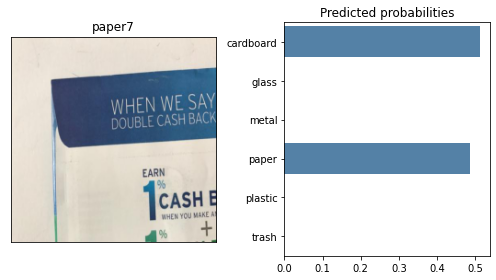

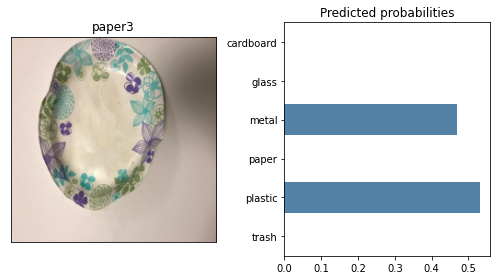

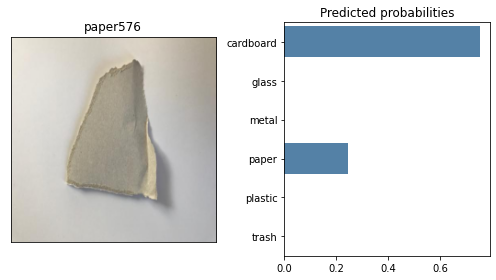

In [ ]:
# Loop over major errors:
for i in range(min([len(conf_preds), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[conf_preds.index[i], :, :, :])
    axs[0].set_title(conf_preds['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].values,
        y=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

#### Plastic

Major errors

In [ ]:
major_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='plastic')
].sort_values('miss_prob', ascending=False).head(10)

print(major_errors['pred_class'].value_counts(normalize=True))
major_errors

glass   0.6250
metal   0.2500
trash   0.1250
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
131     0.0000 1.0000 0.0000 0.0000   0.0000 0.0000      glass    plastic   
71      0.0000 0.9998 0.0000 0.0000   0.0002 0.0000      glass    plastic   
407     0.0000 0.0004 0.9994 0.0000   0.0001 0.0000      metal    plastic   
31      0.0000 0.9990 0.0000 0.0000   0.0010 0.0000      glass    plastic   
220     0.0000 0.9833 0.0000 0.0000   0.0167 0.0000      glass    plastic   
136     0.0000 0.0487 0.9469 0.0006   0.0039 0.0000      metal    plastic   
422     0.0055 0.0009 0.0006 0.0356   0.0200 0.9374      trash    plastic   
387     0.0001 0.6723 0.0043 0.0043   0.3189 0.0000      glass    plastic   

             id  pred_trash  miss_prob  true_prob  
131  plastic152       False     1.0000     0.0000  
71   plastic252       False     0.9998     0.0002  
407   plastic84       False     0.9994     0.0001  
31   plastic114       False     0.9990     0.0010  
220   plastic99       False     0.9833     0.0167  
136   plastic93       False     0.9469     0.0039  
422  plastic146        True     0.9374     0.0200  
387   plastic98       False     0.6723     0.3189

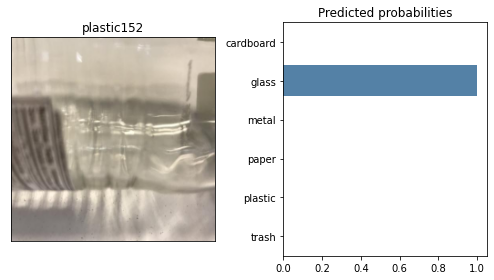

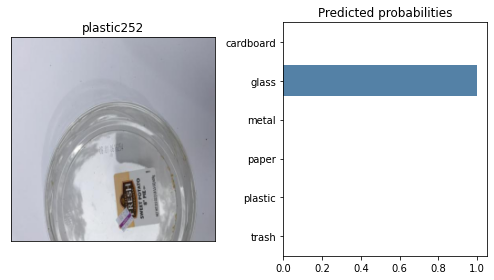

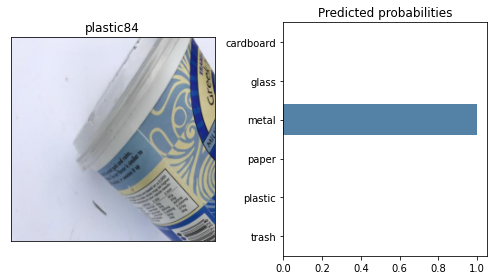

In [ ]:
# Loop over major errors:
for i in range(min([len(major_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[major_errors.index[i], :, :, :])
    axs[0].set_title(major_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].values,
        y=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Minor errors

In [ ]:
minor_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='plastic')
].sort_values('true_prob', ascending=False).head(10)

print(minor_errors['pred_class'].value_counts(normalize=True))
minor_errors

glass   0.6250
metal   0.2500
trash   0.1250
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
387     0.0001 0.6723 0.0043 0.0043   0.3189 0.0000      glass    plastic   
422     0.0055 0.0009 0.0006 0.0356   0.0200 0.9374      trash    plastic   
220     0.0000 0.9833 0.0000 0.0000   0.0167 0.0000      glass    plastic   
136     0.0000 0.0487 0.9469 0.0006   0.0039 0.0000      metal    plastic   
31      0.0000 0.9990 0.0000 0.0000   0.0010 0.0000      glass    plastic   
71      0.0000 0.9998 0.0000 0.0000   0.0002 0.0000      glass    plastic   
407     0.0000 0.0004 0.9994 0.0000   0.0001 0.0000      metal    plastic   
131     0.0000 1.0000 0.0000 0.0000   0.0000 0.0000      glass    plastic   

             id  pred_trash  miss_prob  true_prob  
387   plastic98       False     0.6723     0.3189  
422  plastic146        True     0.9374     0.0200  
220   plastic99       False     0.9833     0.0167  
136   plastic93       False     0.9469     0.0039  
31   plastic114       False     0.9990     0.0010  
71   plastic252       False     0.9998     0.0002  
407   plastic84       False     0.9994     0.0001  
131  plastic152       False     1.0000     0.0000

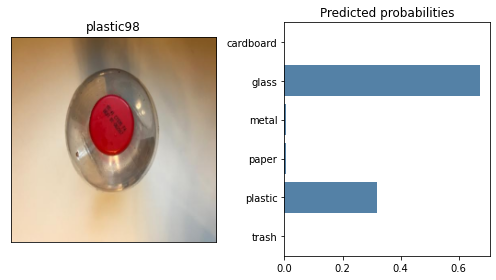

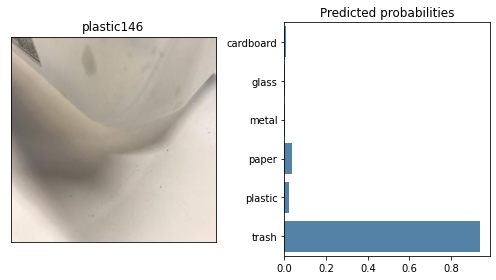

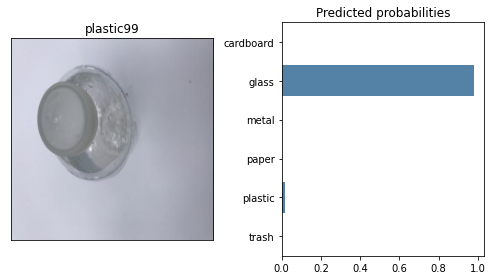

In [ ]:
# Loop over major errors:
for i in range(min([len(minor_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[minor_errors.index[i], :, :, :])
    axs[0].set_title(minor_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].values,
        y=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Confused predictions

In [ ]:
conf_preds = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='plastic')
].sort_values('miss_prob', ascending=True).head(10)

print(conf_preds['pred_class'].value_counts(normalize=True))
conf_preds

glass   0.6250
metal   0.2500
trash   0.1250
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
387     0.0001 0.6723 0.0043 0.0043   0.3189 0.0000      glass    plastic   
422     0.0055 0.0009 0.0006 0.0356   0.0200 0.9374      trash    plastic   
136     0.0000 0.0487 0.9469 0.0006   0.0039 0.0000      metal    plastic   
220     0.0000 0.9833 0.0000 0.0000   0.0167 0.0000      glass    plastic   
31      0.0000 0.9990 0.0000 0.0000   0.0010 0.0000      glass    plastic   
407     0.0000 0.0004 0.9994 0.0000   0.0001 0.0000      metal    plastic   
71      0.0000 0.9998 0.0000 0.0000   0.0002 0.0000      glass    plastic   
131     0.0000 1.0000 0.0000 0.0000   0.0000 0.0000      glass    plastic   

             id  pred_trash  miss_prob  true_prob  
387   plastic98       False     0.6723     0.3189  
422  plastic146        True     0.9374     0.0200  
136   plastic93       False     0.9469     0.0039  
220   plastic99       False     0.9833     0.0167  
31   plastic114       False     0.9990     0.0010  
407   plastic84       False     0.9994     0.0001  
71   plastic252       False     0.9998     0.0002  
131  plastic152       False     1.0000     0.0000

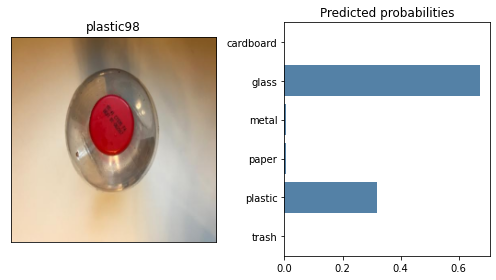

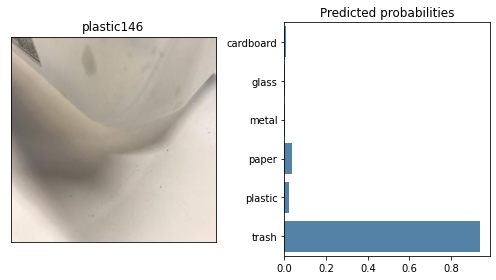

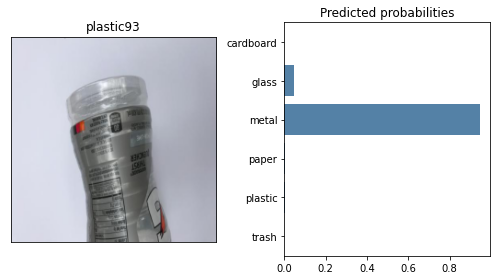

In [ ]:
# Loop over major errors:
for i in range(min([len(conf_preds), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[conf_preds.index[i], :, :, :])
    axs[0].set_title(conf_preds['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].values,
        y=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

#### Trash

Major errors

In [ ]:
major_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='trash')
].sort_values('miss_prob', ascending=False).head(10)

print(major_errors['pred_class'].value_counts(normalize=True))
major_errors

plastic   0.4000
metal     0.3000
paper     0.2000
glass     0.1000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
411     0.0000 0.0000 0.0000 0.0000   1.0000 0.0000    plastic      trash   
57      0.0000 0.0000 0.0000 0.9997   0.0000 0.0002      paper      trash   
345     0.0000 0.0000 0.0005 0.0000   0.9995 0.0000    plastic      trash   
236     0.0000 0.0004 0.9977 0.0001   0.0000 0.0017      metal      trash   
40      0.0000 0.0000 0.0000 0.0000   0.9931 0.0068    plastic      trash   
29      0.0000 0.0000 0.9913 0.0001   0.0000 0.0085      metal      trash   
203     0.0000 0.0004 0.0000 0.0037   0.9765 0.0194    plastic      trash   
62      0.0000 0.0000 0.0247 0.9712   0.0033 0.0008      paper      trash   
262     0.0000 0.0000 0.9624 0.0018   0.0186 0.0173      metal      trash   
182     0.0000 0.9546 0.0021 0.0000   0.0001 0.0433      glass      trash   

           id  pred_trash  miss_prob  true_prob  
411    trash1       False     1.0000     0.0000  
57    trash36       False     0.9997     0.0002  
345    trash4       False     0.9995     0.0000  
236  trash111       False     0.9977     0.0017  
40    trash12       False     0.9931     0.0068  
29    trash28       False     0.9913     0.0085  
203   trash57       False     0.9765     0.0194  
62    trash82       False     0.9712     0.0008  
262   trash46       False     0.9624     0.0173  
182   trash35       False     0.9546     0.0433

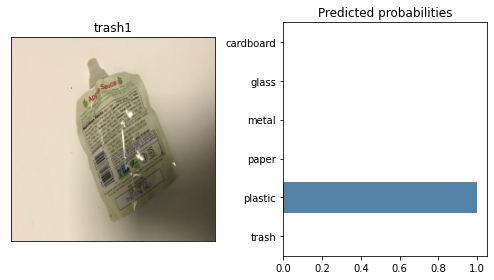

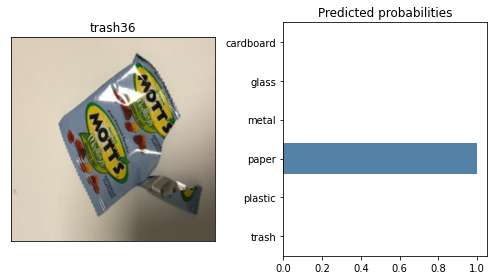

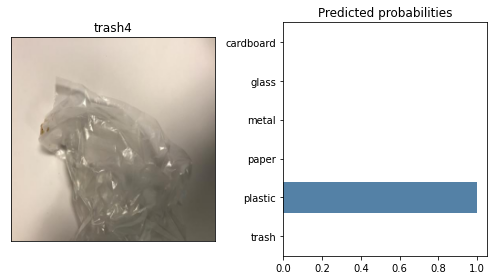

In [ ]:
# Loop over major errors:
for i in range(min([len(major_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[major_errors.index[i], :, :, :])
    axs[0].set_title(major_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].values,
        y=major_errors.loc[major_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Minor errors

In [ ]:
minor_errors = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='trash')
].sort_values('true_prob', ascending=False).head(10)

print(minor_errors['pred_class'].value_counts(normalize=True))
minor_errors

metal     0.5000
plastic   0.3000
paper     0.1000
glass     0.1000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
12      0.0000 0.0001 0.5699 0.0005   0.0004 0.4291      metal      trash   
362     0.0147 0.0011 0.0000 0.6622   0.0005 0.3214      paper      trash   
204     0.0019 0.0001 0.8114 0.0278   0.0001 0.1586      metal      trash   
250     0.0074 0.0000 0.0000 0.0004   0.8758 0.1163    plastic      trash   
182     0.0000 0.9546 0.0021 0.0000   0.0001 0.0433      glass      trash   
203     0.0000 0.0004 0.0000 0.0037   0.9765 0.0194    plastic      trash   
262     0.0000 0.0000 0.9624 0.0018   0.0186 0.0173      metal      trash   
29      0.0000 0.0000 0.9913 0.0001   0.0000 0.0085      metal      trash   
40      0.0000 0.0000 0.0000 0.0000   0.9931 0.0068    plastic      trash   
236     0.0000 0.0004 0.9977 0.0001   0.0000 0.0017      metal      trash   

           id  pred_trash  miss_prob  true_prob  
12    trash40       False     0.5699     0.4291  
362   trash19       False     0.6622     0.3214  
204   trash93       False     0.8114     0.1586  
250  trash132       False     0.8758     0.1163  
182   trash35       False     0.9546     0.0433  
203   trash57       False     0.9765     0.0194  
262   trash46       False     0.9624     0.0173  
29    trash28       False     0.9913     0.0085  
40    trash12       False     0.9931     0.0068  
236  trash111       False     0.9977     0.0017

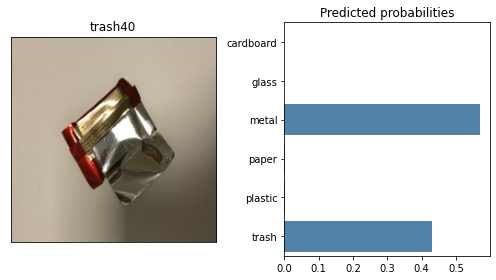

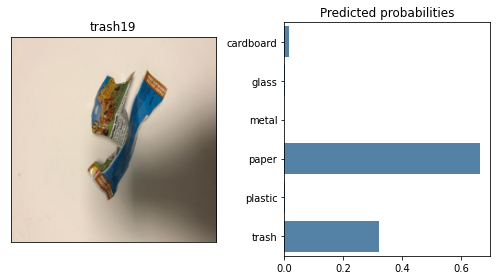

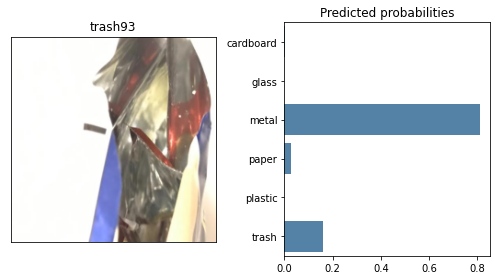

In [ ]:
# Loop over major errors:
for i in range(min([len(minor_errors), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[minor_errors.index[i], :, :, :])
    axs[0].set_title(minor_errors['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].values,
        y=minor_errors.loc[minor_errors.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

Confused predictions

In [ ]:
conf_preds = predictions_prob[
    (predictions_prob.true_class!=predictions_prob.pred_class) &
    (predictions_prob.true_class=='trash')
].sort_values('miss_prob', ascending=True).head(10)

print(conf_preds['pred_class'].value_counts(normalize=True))
conf_preds

metal     0.4000
plastic   0.3000
paper     0.2000
glass     0.1000
Name: pred_class, dtype: float64


cardboard  glass  metal  paper  plastic  trash pred_class true_class  \
12      0.0000 0.0001 0.5699 0.0005   0.0004 0.4291      metal      trash   
362     0.0147 0.0011 0.0000 0.6622   0.0005 0.3214      paper      trash   
204     0.0019 0.0001 0.8114 0.0278   0.0001 0.1586      metal      trash   
250     0.0074 0.0000 0.0000 0.0004   0.8758 0.1163    plastic      trash   
182     0.0000 0.9546 0.0021 0.0000   0.0001 0.0433      glass      trash   
262     0.0000 0.0000 0.9624 0.0018   0.0186 0.0173      metal      trash   
62      0.0000 0.0000 0.0247 0.9712   0.0033 0.0008      paper      trash   
203     0.0000 0.0004 0.0000 0.0037   0.9765 0.0194    plastic      trash   
29      0.0000 0.0000 0.9913 0.0001   0.0000 0.0085      metal      trash   
40      0.0000 0.0000 0.0000 0.0000   0.9931 0.0068    plastic      trash   

           id  pred_trash  miss_prob  true_prob  
12    trash40       False     0.5699     0.4291  
362   trash19       False     0.6622     0.3214  
204   trash93       False     0.8114     0.1586  
250  trash132       False     0.8758     0.1163  
182   trash35       False     0.9546     0.0433  
262   trash46       False     0.9624     0.0173  
62    trash82       False     0.9712     0.0008  
203   trash57       False     0.9765     0.0194  
29    trash28       False     0.9913     0.0085  
40    trash12       False     0.9931     0.0068

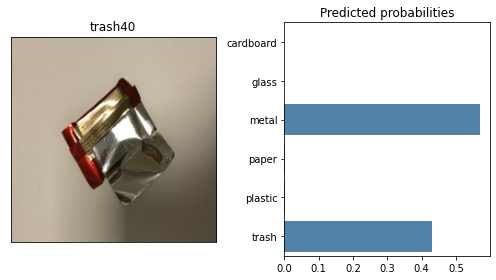

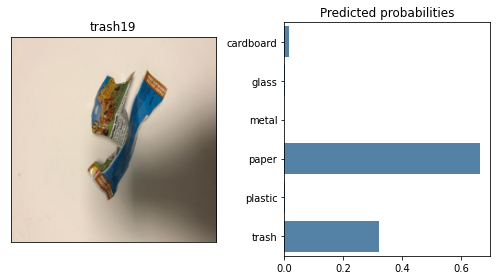

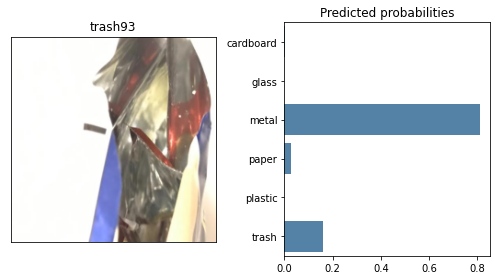

In [ ]:
# Loop over major errors:
for i in range(min([len(conf_preds), 3])):
    fig, axs = plt.subplots(1, 2, figsize=(7,4))

    axs[0].imshow(images_test[conf_preds.index[i], :, :, :])
    axs[0].set_title(conf_preds['id'].iloc[i])
    axs[0].set_xticks(ticks=[])
    axs[0].set_yticks(ticks=[])

    sns.barplot(
        x=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].values,
        y=conf_preds.loc[conf_preds.index[i]][list(label_dict.keys())].index,
        color='#4682b4', ax=axs[1], orient='h'
    )
    axs[1].set_title('Predicted probabilities')

    plt.tight_layout()

<a id='model_arch'></a>

## Model architecture

ANN Model (1671641950)


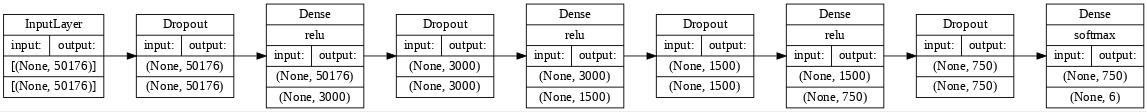

In [ ]:
print('\033[1mANN Model (1671641950)\033[0m')
plot_model(
    models['1671641950'].model,
    show_layer_names=False, show_shapes=True, show_layer_activations=True,
    expand_nested=True, rankdir='LR', dpi=65,
    to_file='../artifacts/arch_1671641950.jpg'
)

CNN Model (1671648238)


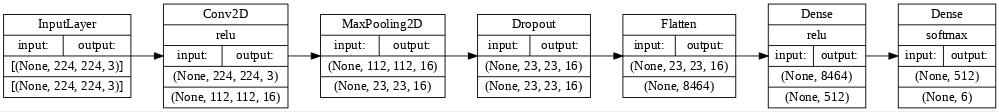

In [ ]:
print('\033[1mCNN Model (1671648238)\033[0m')
plot_model(
    models['1671648238'].model,
    show_layer_names=False, show_shapes=True, show_layer_activations=True,
    expand_nested=True, rankdir='LR', dpi=65,
    to_file='../artifacts/arch_1671648238.jpg'
)

Transfer Learning Model (1672278906)


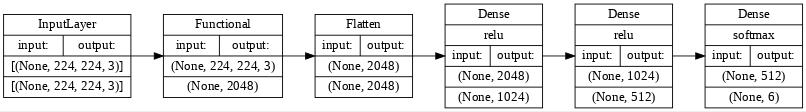

In [ ]:
print('\033[1mTransfer Learning Model (1672278906)\033[0m')
plot_model(
    models['1672278906'].model,
    show_layer_names=False, show_shapes=True, show_layer_activations=True,
    expand_nested=False, rankdir='LR', dpi=65,
    to_file='../artifacts/arch_1672278906.jpg'
)

Transfer Learning Model (1672278906)


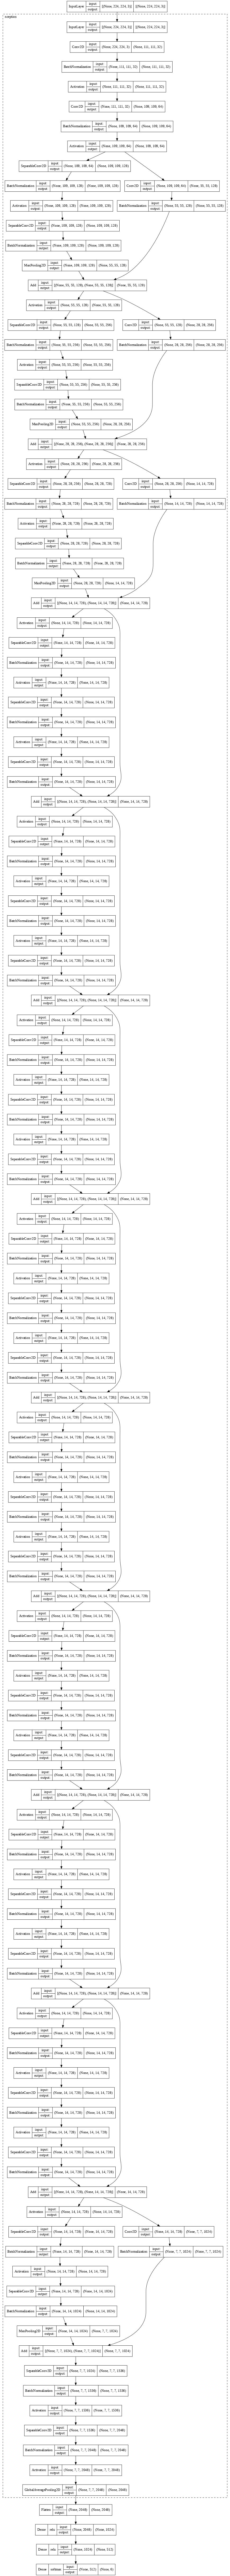

In [ ]:
print('\033[1mTransfer Learning Model (1672278906)\033[0m')
plot_model(
    models['1672278906'].model,
    show_layer_names=False, show_shapes=True, show_layer_activations=True,
    expand_nested=True, rankdir='TB', dpi=65,
    to_file='../artifacts/arch_1672278906_exp.jpg'
)